[Glove embeddings](https://nlp.stanford.edu/projects/glove/) file required: "glove.6B.300d.txt".

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import time
import random
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from tqdm.notebook import tqdm
from seqeval.metrics import accuracy_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = "predfull" #"asp" "predfull"

In [3]:
if dataset == "asp":
    CONLL_DATA = "sequence_labelling_aspect/"
else:
    CONLL_DATA = "sequence_labelling_predicate/"

In [4]:
"""input/output data wrapper for CoNNL file format used in  NER-2003 Shared Task dataset"""
import codecs

def get_words_num(word_sequences):
    return sum(len(word_seq) for word_seq in word_sequences)


class DataIOConnlNer2003():
    """DataIONerConnl2003 is an input/output data wrapper for CoNNL-2003 Shared Task file format.
    Tjong Kim Sang, Erik F., and Fien De Meulder. "Introduction to the CoNLL-2003 shared task: Language-independent
    named entity recognition." Proceedings of the seventh conference on Natural language learning at HLT-NAACL
    2003-Volume 4. Association for Computational Linguistics, 2003.
    """
    def read_train_dev_test(self, train, dev, test):
        word_sequences_train, tag_sequences_train = self.read_data(fn=train)
        word_sequences_dev, tag_sequences_dev = self.read_data(fn=dev)
        word_sequences_test, tag_sequences_test = self.read_data(fn=test)
        return word_sequences_train, tag_sequences_train, word_sequences_dev, tag_sequences_dev, word_sequences_test, \
               tag_sequences_test

    def read_data(self, fn, verbose=True, column_no=-1):
        word_sequences = list()
        tag_sequences = list()
        with codecs.open(fn, 'r', 'utf-8') as f:
            lines = f.readlines()
        curr_words = list()
        curr_tags = list()
        for k in range(len(lines)):
            line = lines[k].strip()
            if len(line) == 0 or line.startswith('-DOCSTART-'): # new sentence or new document
                if len(curr_words) > 0:
                    word_sequences.append(curr_words)
                    tag_sequences.append(curr_tags)
                    curr_words = list()
                    curr_tags = list()
                continue
            strings = line.split('\t')
            word = strings[0]
            tag = strings[column_no] # be default, we take the last tag
            curr_words.append(word)
            curr_tags.append(tag)
            if k == len(lines) - 1:
                word_sequences.append(curr_words)
                tag_sequences.append(curr_tags)
        if verbose:
            print('Loading from %s: %d samples, %d words.' % (fn, len(word_sequences), get_words_num(word_sequences)))
        return word_sequences, tag_sequences

In [5]:
io = DataIOConnlNer2003()

In [6]:
if dataset == "asp":
    train_words, train_labels, dev_words, dev_labels, test_words, test_labels = \
    io.read_train_dev_test(CONLL_DATA + "train_aspect.tsv",
                           CONLL_DATA + "dev_aspect.tsv",
                           CONLL_DATA + "test_aspect.tsv")
else:
    train_words, train_labels, dev_words, dev_labels, test_words, test_labels = \
    io.read_train_dev_test(CONLL_DATA + "train_pred_full.tsv",
                           CONLL_DATA + "dev_pred_full.tsv",
                           CONLL_DATA + "test_pred_full.tsv")

Loading from sequence_labelling_predicate/train_pred_full.tsv: 3077 samples, 89350 words.
Loading from sequence_labelling_predicate/dev_pred_full.tsv: 402 samples, 12360 words.
Loading from sequence_labelling_predicate/test_pred_full.tsv: 488 samples, 13736 words.


In [7]:
tag2ix = {
    '<pad>': 0,
    'O': 1,
    'B-OBJ': 2,
    'I-OBJ': 3
}
if dataset == "asp":
    tag2ix['B-ASPECT'] = 4
    tag2ix['I-ASPECT'] = 5
else:
    tag2ix['B-PREDFULL'] = 4
    tag2ix['I-PREDFULL'] = 5

ix2tag = {value: key for key, value in tag2ix.items()}

In [8]:
conll_train = list(zip(train_words, train_labels))
conll_dev = list(zip(dev_words, dev_labels))
conll_test = list(zip(test_words, test_labels))

In [9]:
# load the embeddings
def load_embeddings(emb_path):
    clf_embeddings = {}
    emb_vocab = set()
    for line in open(emb_path):
        line = line.strip('\n').split()
        word, emb = line[0], line[1:]
        emb = [float(e) for e in emb]
        clf_embeddings[word] = emb
    for w in clf_embeddings:
        emb_vocab.add(w)
    word2idx = {w: idx for (idx, w) in enumerate(emb_vocab)}
    max_val = max(word2idx.values())
    
    word2idx['UNK'] = max_val + 1
    word2idx['<pad>'] = max_val + 2
    emb_dim = len(list(clf_embeddings.values())[0])
    clf_embeddings['UNK'] = [0.0 for i in range(emb_dim)]
    clf_embeddings['<pad>'] = [0.0 for i in range(emb_dim)]
    
    embeddings = [[] for i in range(len(word2idx))]
    for w in word2idx:
        embeddings[word2idx[w]] = clf_embeddings[w]
    embeddings = torch.Tensor(embeddings)
    return embeddings, word2idx
embeddings, vocab = load_embeddings('glove.6B.300d.txt')

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
def make_tensors(batch):
    tokens, labels = tuple(zip(*batch))
    pad = vocab['<pad>']
    pad_label = tag2ix['<pad>']
    lines_ix = []
    tags_ix = []
    seq_lens = []
    for i in range(len(tokens)):
        line_ix = [vocab.get(l, vocab['UNK']) for l in tokens[i]]
        lines_ix.append(torch.LongTensor(line_ix))
        tag_ix = [tag2ix[l] for l in labels[i]]
        tags_ix.append(torch.LongTensor(tag_ix))
        seq_lens.append(len(line_ix))
    tensor_x = pad_sequence(lines_ix, batch_first=True, padding_value=pad)
    tensor_y = pad_sequence(tags_ix, batch_first=True, padding_value=pad_label)
    return tensor_x, tensor_y, seq_lens

In [12]:
def make_tensors_predict(batch):
    tokens = batch
    pad = vocab['<pad>']
    lines_ix = []
    seq_lens = []
    for i in range(len(tokens)):
        line_ix = [vocab.get(l, vocab['UNK']) for l in tokens[i]]
        lines_ix.append(torch.LongTensor(line_ix))
        seq_lens.append(len(line_ix))
    tensor_x = pad_sequence(lines_ix, batch_first=True, padding_value=pad)
    return tensor_x, seq_lens

In [13]:
class LSTMTagger(nn.Module):

    def __init__(self, embeddings, hidden_dim, tagset_size, lstm_layer=1, dropout_ratio=0.5):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        # load pre-trained embeddings
        self.embedding = nn.Embedding.from_pretrained(embeddings)
        # embeddings are not fine-tuned
        self.embedding.weight.requires_grad = False
        
        self.dropout = torch.nn.Dropout(p=dropout_ratio)
        
        # RNN layer with LSTM cells
        self.lstm = nn.LSTM(input_size=self.embedding.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=lstm_layer, 
                            bidirectional=True,
                            batch_first=True)
        
        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(2 * hidden_dim, tagset_size)
        
#         self.nll_loss = nn.NLLLoss(ignore_index=0)

    def forward(self, sents, seq_lens, device):
        
        _, max_seq_len = sents.shape

        embeds = self.embedding(sents)
        
        embeds_d = self.dropout(embeds)
        
        embeds_packed, reverse_sort_index = self.pack(embeds_d, seq_lens, device)
        
        lstm_out_packed, _ = self.lstm(embeds_packed)
        
        lstm_out_unpacked = self.unpack(lstm_out_packed, max_seq_len, reverse_sort_index)

        tag_space = self.hidden2tag(lstm_out_unpacked)

        tag_scores = F.log_softmax(tag_space, dim=2)
        return tag_scores
    
    def sort_by_seq_len_list(self, seq_len_list, device):
        data_num = len(seq_len_list)
        sort_indices = sorted(range(len(seq_len_list)), key=seq_len_list.__getitem__, reverse=True)
        reverse_sort_indices = [-1 for _ in range(data_num)]
        for i in range(data_num):
            reverse_sort_indices[sort_indices[i]] = i
        sort_index = torch.tensor(sort_indices, dtype=torch.long).to(device)
        reverse_sort_index = torch.tensor(reverse_sort_indices, dtype=torch.long).to(device)
        return sorted(seq_len_list, reverse=True), sort_index, reverse_sort_index
    
    def pack(self, input_tensor, seq_len_list, device):
        sorted_seq_len_list, sort_index, reverse_sort_index = self.sort_by_seq_len_list(seq_len_list, device)
        input_tensor_sorted = torch.index_select(input_tensor, dim=0, index=sort_index)
        return pack_padded_sequence(input_tensor_sorted, lengths=sorted_seq_len_list, batch_first=True), \
               reverse_sort_index

    def unpack(self, output_packed, max_seq_len, reverse_sort_index):
        output_tensor_sorted, _ = pad_packed_sequence(output_packed, batch_first=True, total_length=max_seq_len)
        output_tensor = torch.index_select(output_tensor_sorted, dim=0, index=reverse_sort_index)
        return output_tensor

In [14]:
def train_model_epoch(train_dataset, model, optimizer, bs):
    model.train()
    train_loss = 0
    train_acc = 0
    data = DataLoader(train_dataset, batch_size=bs, 
                      shuffle=True,
                      collate_fn=make_tensors,
                      num_workers=0)
    
    for batch in tqdm(data):
        features, labels, seq_lens = batch
        
        labels = labels.to(device)
        features = features.to(device)
        
        optimizer.zero_grad()
        output = model(features, seq_lens, device)
        loss = loss_function(output.permute(0, 2, 1), labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss += loss.item()

    return train_loss * bs / len(train_dataset)


def train(train_dataset, test_dataset, model, optimizer, n_epochs, bs, pred_bs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    print('Training...')
    for epoch in range(n_epochs):
        print('-' * 50)
        print('EPOCH ' + str(epoch))
        train_loss = train_model_epoch(train_dataset, model, optimizer, bs=bs)
        print(f'Train loss {train_loss:.6f}')
        print('Evaluating...')
        train_loss, train_acc = test(train_dataset, model, batch_size=pred_bs, device=device)
        test_loss, test_acc = test(test_dataset, model, batch_size=pred_bs, device=device)
        print(f'Train loss {train_loss:.6f}')
        print(f'Train accuracy: {train_acc: .6f}')
        print(f'Test loss: {test_loss:.6f}')
        print(f'Test accuracy: {test_acc: .6f}')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(test_loss)
        val_accs.append(test_acc)
    print('Finished training.')
    return train_losses, train_accs, val_losses, val_accs


def test(test_dataset, model, batch_size, device=None):
    model.eval()
    loss = 0
    acc = 0
    preds = []
    labs = []
    data_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=make_tensors)
    for sample in tqdm(data_loader):
        features, labels, seq_lens = sample
        if device is not None:
            labels = labels.to(device)
            features = features.to(device)
        with torch.no_grad():
            output = model(features, seq_lens, device)
            loss += loss_function(output.permute(0, 2, 1), labels).item()
            y_pred = torch.argmax(output, dim=2)
            y_true = labels
            y_pred = y_pred.tolist()
            y_true = y_true.tolist()
            for i, sent_len in enumerate(seq_lens):
                y_pred[i] = y_pred[i][:sent_len]
                y_true[i] = y_true[i][:sent_len]
            preds += y_pred
            labs += y_true
    
    acc = accuracy_score(labs, preds)
    
    return loss * batch_size / len(test_dataset), acc

def predict(input_dataset, model, batch_size, device=None):
    preds = []
    model.eval()
    data_loader = DataLoader(input_dataset, batch_size=batch_size, collate_fn=make_tensors_predict)
    for sample in tqdm(data_loader):
        features, seq_lens = sample
        if device is not None:
            features = features.to(device)
        with torch.no_grad():
            output = model(features, seq_lens, device)
            
            y_pred = torch.argmax(output, dim=2)
            y_pred = y_pred.tolist()
            for i, sent_len in enumerate(seq_lens):
                y_pred[i] = y_pred[i][:sent_len]
            y_pred = [[ix2tag[w] for w in sent] for sent in y_pred]
            preds += y_pred
    
    return preds

In [15]:
N_EPOCHS = 500
BATCH_SIZE = 24
LEARNING_RATE = 1e-6
ALPHA = 0
hidden_dim = 128
layers = 1
PRED_BATCH_SIZE = 100

model = LSTMTagger(embeddings, hidden_dim, len(tag2ix), lstm_layer=layers)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=ALPHA)
loss_function = nn.NLLLoss(ignore_index=tag2ix['<pad>'])
# loss_function = nn.CrossEntropyLoss(ignore_index=tag2ix['<pad>'])

model = model.to(device)
loss_function = loss_function.to(device)

train_data = conll_train.copy()


train_losses, train_accs, val_losses, val_accs = train(train_data, conll_dev, 
                                                       model, optimizer, 
                                                       n_epochs=N_EPOCHS, 
                                                       bs=BATCH_SIZE, 
                                                       pred_bs=PRED_BATCH_SIZE)

Training...
--------------------------------------------------
EPOCH 0



Train loss 1.819770
Evaluating...



Train loss 1.807779
Train accuracy:  0.072927
Test loss: 2.227932
Test accuracy:  0.096764
--------------------------------------------------
EPOCH 1



Train loss 1.802586
Evaluating...



Train loss 1.789645
Train accuracy:  0.148226
Test loss: 2.205716
Test accuracy:  0.179450
--------------------------------------------------
EPOCH 2



Train loss 1.786191
Evaluating...



Train loss 1.771466
Train accuracy:  0.274180
Test loss: 2.183440
Test accuracy:  0.306311
--------------------------------------------------
EPOCH 3



Train loss 1.769672
Evaluating...



Train loss 1.753191
Train accuracy:  0.430767
Test loss: 2.161034
Test accuracy:  0.455906
--------------------------------------------------
EPOCH 4



Train loss 1.753606
Evaluating...



Train loss 1.734761
Train accuracy:  0.573520
Test loss: 2.138431
Test accuracy:  0.591100
--------------------------------------------------
EPOCH 5



Train loss 1.736443
Evaluating...



Train loss 1.716076
Train accuracy:  0.684063
Test loss: 2.115501
Test accuracy:  0.700566
--------------------------------------------------
EPOCH 6



Train loss 1.719304
Evaluating...



Train loss 1.697160
Train accuracy:  0.759720
Test loss: 2.092284
Test accuracy:  0.768932
--------------------------------------------------
EPOCH 7



Train loss 1.701345
Evaluating...



Train loss 1.677945
Train accuracy:  0.806928
Test loss: 2.068683
Test accuracy:  0.812621
--------------------------------------------------
EPOCH 8



Train loss 1.684039
Evaluating...



Train loss 1.658428
Train accuracy:  0.836307
Test loss: 2.044703
Test accuracy:  0.838511
--------------------------------------------------
EPOCH 9



Train loss 1.666005
Evaluating...



Train loss 1.638563
Train accuracy:  0.855781
Test loss: 2.020276
Test accuracy:  0.856553
--------------------------------------------------
EPOCH 10



Train loss 1.647527
Evaluating...



Train loss 1.618283
Train accuracy:  0.869245
Test loss: 1.995325
Test accuracy:  0.868447
--------------------------------------------------
EPOCH 11



Train loss 1.628931
Evaluating...



Train loss 1.597560
Train accuracy:  0.878769
Test loss: 1.969816
Test accuracy:  0.876294
--------------------------------------------------
EPOCH 12



Train loss 1.609684
Evaluating...



Train loss 1.576353
Train accuracy:  0.885641
Test loss: 1.943691
Test accuracy:  0.882201
--------------------------------------------------
EPOCH 13



Train loss 1.591456
Evaluating...



Train loss 1.554680
Train accuracy:  0.890453
Test loss: 1.916977
Test accuracy:  0.886893
--------------------------------------------------
EPOCH 14



Train loss 1.570621
Evaluating...



Train loss 1.532461
Train accuracy:  0.894482
Test loss: 1.889574
Test accuracy:  0.888835
--------------------------------------------------
EPOCH 15



Train loss 1.550329
Evaluating...



Train loss 1.509635
Train accuracy:  0.897146
Test loss: 1.861416
Test accuracy:  0.890696
--------------------------------------------------
EPOCH 16



Train loss 1.529446
Evaluating...



Train loss 1.486229
Train accuracy:  0.899250
Test loss: 1.832514
Test accuracy:  0.892476
--------------------------------------------------
EPOCH 17



Train loss 1.508360
Evaluating...



Train loss 1.462185
Train accuracy:  0.900951
Test loss: 1.802816
Test accuracy:  0.893770
--------------------------------------------------
EPOCH 18



Train loss 1.485641
Evaluating...



Train loss 1.437446
Train accuracy:  0.901992
Test loss: 1.772241
Test accuracy:  0.894498
--------------------------------------------------
EPOCH 19



Train loss 1.463606
Evaluating...



Train loss 1.411993
Train accuracy:  0.902988
Test loss: 1.740769
Test accuracy:  0.894822
--------------------------------------------------
EPOCH 20



Train loss 1.440730
Evaluating...



Train loss 1.385869
Train accuracy:  0.903682
Test loss: 1.708474
Test accuracy:  0.895146
--------------------------------------------------
EPOCH 21



Train loss 1.416701
Evaluating...



Train loss 1.358939
Train accuracy:  0.904242
Test loss: 1.675150
Test accuracy:  0.895631
--------------------------------------------------
EPOCH 22



Train loss 1.391919
Evaluating...



Train loss 1.331225
Train accuracy:  0.904667
Test loss: 1.640854
Test accuracy:  0.896036
--------------------------------------------------
EPOCH 23



Train loss 1.365809
Evaluating...



Train loss 1.302750
Train accuracy:  0.905092
Test loss: 1.605611
Test accuracy:  0.896036
--------------------------------------------------
EPOCH 24



Train loss 1.339229
Evaluating...



Train loss 1.273420
Train accuracy:  0.905350
Test loss: 1.569294
Test accuracy:  0.896197
--------------------------------------------------
EPOCH 25



Train loss 1.313949
Evaluating...



Train loss 1.243305
Train accuracy:  0.905529
Test loss: 1.532009
Test accuracy:  0.896278
--------------------------------------------------
EPOCH 26



Train loss 1.286527
Evaluating...



Train loss 1.212344
Train accuracy:  0.905775
Test loss: 1.493683
Test accuracy:  0.896683
--------------------------------------------------
EPOCH 27



Train loss 1.257481
Evaluating...



Train loss 1.180613
Train accuracy:  0.905954
Test loss: 1.454392
Test accuracy:  0.896926
--------------------------------------------------
EPOCH 28



Train loss 1.228170
Evaluating...



Train loss 1.148026
Train accuracy:  0.906010
Test loss: 1.414053
Test accuracy:  0.897006
--------------------------------------------------
EPOCH 29



Train loss 1.198747
Evaluating...



Train loss 1.114647
Train accuracy:  0.906100
Test loss: 1.372733
Test accuracy:  0.897087
--------------------------------------------------
EPOCH 30



Train loss 1.169306
Evaluating...



Train loss 1.080618
Train accuracy:  0.906144
Test loss: 1.330628
Test accuracy:  0.897087
--------------------------------------------------
EPOCH 31



Train loss 1.137159
Evaluating...



Train loss 1.045843
Train accuracy:  0.906200
Test loss: 1.287607
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 32



Train loss 1.105741
Evaluating...



Train loss 1.010445
Train accuracy:  0.906267
Test loss: 1.243840
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 33



Train loss 1.074264
Evaluating...



Train loss 0.974539
Train accuracy:  0.906301
Test loss: 1.199464
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 34



Train loss 1.039887
Evaluating...



Train loss 0.938199
Train accuracy:  0.906323
Test loss: 1.154578
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 35



Train loss 1.005044
Evaluating...



Train loss 0.901636
Train accuracy:  0.906346
Test loss: 1.109450
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 36



Train loss 0.972929
Evaluating...



Train loss 0.864978
Train accuracy:  0.906368
Test loss: 1.064238
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 37



Train loss 0.936749
Evaluating...



Train loss 0.828455
Train accuracy:  0.906379
Test loss: 1.019257
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 38



Train loss 0.901720
Evaluating...



Train loss 0.792316
Train accuracy:  0.906391
Test loss: 0.974810
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 39



Train loss 0.869125
Evaluating...



Train loss 0.756816
Train accuracy:  0.906402
Test loss: 0.931235
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 40



Train loss 0.833363
Evaluating...



Train loss 0.722255
Train accuracy:  0.906413
Test loss: 0.888901
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 41



Train loss 0.799860
Evaluating...



Train loss 0.688850
Train accuracy:  0.906413
Test loss: 0.848097
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 42



Train loss 0.766607
Evaluating...



Train loss 0.657046
Train accuracy:  0.906413
Test loss: 0.809367
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 43



Train loss 0.731821
Evaluating...



Train loss 0.627024
Train accuracy:  0.906413
Test loss: 0.772945
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 44



Train loss 0.701648
Evaluating...



Train loss 0.599045
Train accuracy:  0.906413
Test loss: 0.739160
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 45



Train loss 0.672432
Evaluating...



Train loss 0.573332
Train accuracy:  0.906413
Test loss: 0.708285
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 46



Train loss 0.643310
Evaluating...



Train loss 0.549837
Train accuracy:  0.906413
Test loss: 0.680260
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 47



Train loss 0.617261
Evaluating...



Train loss 0.528843
Train accuracy:  0.906413
Test loss: 0.655427
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 48



Train loss 0.592800
Evaluating...



Train loss 0.510234
Train accuracy:  0.906413
Test loss: 0.633617
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 49



Train loss 0.571032
Evaluating...



Train loss 0.493971
Train accuracy:  0.906424
Test loss: 0.614772
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 50



Train loss 0.549287
Evaluating...



Train loss 0.479925
Train accuracy:  0.906424
Test loss: 0.598704
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 51



Train loss 0.530357
Evaluating...



Train loss 0.467836
Train accuracy:  0.906424
Test loss: 0.585089
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 52



Train loss 0.514902
Evaluating...



Train loss 0.457542
Train accuracy:  0.906424
Test loss: 0.573699
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 53



Train loss 0.500141
Evaluating...



Train loss 0.448813
Train accuracy:  0.906424
Test loss: 0.564245
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 54



Train loss 0.486771
Evaluating...



Train loss 0.441439
Train accuracy:  0.906424
Test loss: 0.556457
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 55



Train loss 0.473974
Evaluating...



Train loss 0.435265
Train accuracy:  0.906424
Test loss: 0.550116
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 56



Train loss 0.464547
Evaluating...



Train loss 0.430086
Train accuracy:  0.906424
Test loss: 0.544967
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 57



Train loss 0.455756
Evaluating...



Train loss 0.425702
Train accuracy:  0.906424
Test loss: 0.540769
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 58



Train loss 0.448465
Evaluating...



Train loss 0.421993
Train accuracy:  0.906424
Test loss: 0.537369
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 59



Train loss 0.441273
Evaluating...



Train loss 0.418826
Train accuracy:  0.906424
Test loss: 0.534595
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 60



Train loss 0.435161
Evaluating...



Train loss 0.416093
Train accuracy:  0.906424
Test loss: 0.532322
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 61



Train loss 0.432566
Evaluating...



Train loss 0.413690
Train accuracy:  0.906424
Test loss: 0.530417
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 62



Train loss 0.424705
Evaluating...



Train loss 0.411546
Train accuracy:  0.906424
Test loss: 0.528791
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 63



Train loss 0.422566
Evaluating...



Train loss 0.409587
Train accuracy:  0.906424
Test loss: 0.527358
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 64



Train loss 0.418665
Evaluating...



Train loss 0.407775
Train accuracy:  0.906424
Test loss: 0.526083
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 65



Train loss 0.415128
Evaluating...



Train loss 0.406047
Train accuracy:  0.906424
Test loss: 0.524886
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 66



Train loss 0.410644
Evaluating...



Train loss 0.404368
Train accuracy:  0.906424
Test loss: 0.523707
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 67



Train loss 0.407459
Evaluating...



Train loss 0.402746
Train accuracy:  0.906424
Test loss: 0.522575
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 68



Train loss 0.404627
Evaluating...



Train loss 0.401086
Train accuracy:  0.906424
Test loss: 0.521379
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 69



Train loss 0.402797
Evaluating...



Train loss 0.399454
Train accuracy:  0.906424
Test loss: 0.520212
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 70



Train loss 0.399766
Evaluating...



Train loss 0.397812
Train accuracy:  0.906424
Test loss: 0.519012
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 71



Train loss 0.396253
Evaluating...



Train loss 0.396077
Train accuracy:  0.906424
Test loss: 0.517644
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 72



Train loss 0.394179
Evaluating...



Train loss 0.394372
Train accuracy:  0.906424
Test loss: 0.516325
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 73



Train loss 0.392974
Evaluating...



Train loss 0.392648
Train accuracy:  0.906424
Test loss: 0.514961
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 74



Train loss 0.389975
Evaluating...



Train loss 0.390810
Train accuracy:  0.906424
Test loss: 0.513425
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 75



Train loss 0.388253
Evaluating...



Train loss 0.389014
Train accuracy:  0.906424
Test loss: 0.511947
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 76



Train loss 0.387071
Evaluating...



Train loss 0.387206
Train accuracy:  0.906424
Test loss: 0.510457
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 77



Train loss 0.384326
Evaluating...



Train loss 0.385441
Train accuracy:  0.906424
Test loss: 0.509012
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 78



Train loss 0.382633
Evaluating...



Train loss 0.383605
Train accuracy:  0.906424
Test loss: 0.507448
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 79



Train loss 0.381761
Evaluating...



Train loss 0.381699
Train accuracy:  0.906424
Test loss: 0.505789
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 80



Train loss 0.378268
Evaluating...



Train loss 0.379830
Train accuracy:  0.906424
Test loss: 0.504177
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 81



Train loss 0.376671
Evaluating...



Train loss 0.377998
Train accuracy:  0.906424
Test loss: 0.502610
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 82



Train loss 0.374606
Evaluating...



Train loss 0.376160
Train accuracy:  0.906424
Test loss: 0.501021
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 83



Train loss 0.374277
Evaluating...



Train loss 0.374391
Train accuracy:  0.906424
Test loss: 0.499538
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 84



Train loss 0.370043
Evaluating...



Train loss 0.372518
Train accuracy:  0.906424
Test loss: 0.497879
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 85



Train loss 0.369694
Evaluating...



Train loss 0.370729
Train accuracy:  0.906424
Test loss: 0.496343
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 86



Train loss 0.367236
Evaluating...



Train loss 0.369023
Train accuracy:  0.906424
Test loss: 0.494930
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 87



Train loss 0.364960
Evaluating...



Train loss 0.367254
Train accuracy:  0.906424
Test loss: 0.493415
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 88



Train loss 0.364325
Evaluating...



Train loss 0.365492
Train accuracy:  0.906424
Test loss: 0.491895
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 89



Train loss 0.363487
Evaluating...



Train loss 0.363756
Train accuracy:  0.906424
Test loss: 0.490392
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 90



Train loss 0.361086
Evaluating...



Train loss 0.362068
Train accuracy:  0.906424
Test loss: 0.488943
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 91



Train loss 0.360023
Evaluating...



Train loss 0.360434
Train accuracy:  0.906424
Test loss: 0.487572
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 92



Train loss 0.356250
Evaluating...



Train loss 0.358899
Train accuracy:  0.906424
Test loss: 0.486346
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 93



Train loss 0.355492
Evaluating...



Train loss 0.357345
Train accuracy:  0.906424
Test loss: 0.485081
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 94



Train loss 0.353647
Evaluating...



Train loss 0.355818
Train accuracy:  0.906424
Test loss: 0.483830
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 95



Train loss 0.353421
Evaluating...



Train loss 0.354318
Train accuracy:  0.906424
Test loss: 0.482617
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 96



Train loss 0.351448
Evaluating...



Train loss 0.352796
Train accuracy:  0.906424
Test loss: 0.481336
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 97



Train loss 0.350385
Evaluating...



Train loss 0.351369
Train accuracy:  0.906424
Test loss: 0.480208
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 98



Train loss 0.348617
Evaluating...



Train loss 0.349961
Train accuracy:  0.906424
Test loss: 0.479083
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 99



Train loss 0.347434
Evaluating...



Train loss 0.348574
Train accuracy:  0.906424
Test loss: 0.477979
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 100



Train loss 0.348978
Evaluating...



Train loss 0.347233
Train accuracy:  0.906424
Test loss: 0.476937
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 101



Train loss 0.345818
Evaluating...



Train loss 0.345904
Train accuracy:  0.906424
Test loss: 0.475873
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 102



Train loss 0.343818
Evaluating...



Train loss 0.344600
Train accuracy:  0.906424
Test loss: 0.474848
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 103



Train loss 0.345882
Evaluating...



Train loss 0.343450
Train accuracy:  0.906424
Test loss: 0.474067
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 104



Train loss 0.341876
Evaluating...



Train loss 0.342116
Train accuracy:  0.906424
Test loss: 0.472947
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 105



Train loss 0.339684
Evaluating...



Train loss 0.340965
Train accuracy:  0.906424
Test loss: 0.472119
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 106



Train loss 0.340651
Evaluating...



Train loss 0.339840
Train accuracy:  0.906424
Test loss: 0.471335
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 107



Train loss 0.338175
Evaluating...



Train loss 0.338578
Train accuracy:  0.906424
Test loss: 0.470285
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 108



Train loss 0.337649
Evaluating...



Train loss 0.337485
Train accuracy:  0.906424
Test loss: 0.469533
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 109



Train loss 0.336445
Evaluating...



Train loss 0.336337
Train accuracy:  0.906424
Test loss: 0.468666
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 110



Train loss 0.334495
Evaluating...



Train loss 0.335281
Train accuracy:  0.906424
Test loss: 0.467931
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 111



Train loss 0.333595
Evaluating...



Train loss 0.334208
Train accuracy:  0.906424
Test loss: 0.467166
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 112



Train loss 0.333902
Evaluating...



Train loss 0.333093
Train accuracy:  0.906424
Test loss: 0.466326
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 113



Train loss 0.331664
Evaluating...



Train loss 0.331984
Train accuracy:  0.906424
Test loss: 0.465475
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 114



Train loss 0.330940
Evaluating...



Train loss 0.330939
Train accuracy:  0.906424
Test loss: 0.464729
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 115



Train loss 0.330250
Evaluating...



Train loss 0.329847
Train accuracy:  0.906424
Test loss: 0.463897
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 116



Train loss 0.328251
Evaluating...



Train loss 0.328776
Train accuracy:  0.906424
Test loss: 0.463083
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 117



Train loss 0.327037
Evaluating...



Train loss 0.327716
Train accuracy:  0.906424
Test loss: 0.462274
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 118



Train loss 0.327136
Evaluating...



Train loss 0.326700
Train accuracy:  0.906424
Test loss: 0.461551
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 119



Train loss 0.325287
Evaluating...



Train loss 0.325671
Train accuracy:  0.906424
Test loss: 0.460785
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 120



Train loss 0.324697
Evaluating...



Train loss 0.324644
Train accuracy:  0.906424
Test loss: 0.460027
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 121



Train loss 0.323747
Evaluating...



Train loss 0.323574
Train accuracy:  0.906424
Test loss: 0.459183
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 122



Train loss 0.323580
Evaluating...



Train loss 0.322532
Train accuracy:  0.906424
Test loss: 0.458382
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 123



Train loss 0.322105
Evaluating...



Train loss 0.321505
Train accuracy:  0.906424
Test loss: 0.457610
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 124



Train loss 0.320831
Evaluating...



Train loss 0.320564
Train accuracy:  0.906424
Test loss: 0.456967
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 125



Train loss 0.321637
Evaluating...



Train loss 0.319496
Train accuracy:  0.906424
Test loss: 0.456099
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 126



Train loss 0.323042
Evaluating...



Train loss 0.318520
Train accuracy:  0.906424
Test loss: 0.455380
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 127



Train loss 0.317617
Evaluating...



Train loss 0.317424
Train accuracy:  0.906424
Test loss: 0.454429
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 128



Train loss 0.316912
Evaluating...



Train loss 0.316422
Train accuracy:  0.906424
Test loss: 0.453663
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 129



Train loss 0.315818
Evaluating...



Train loss 0.315428
Train accuracy:  0.906424
Test loss: 0.452903
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 130



Train loss 0.316262
Evaluating...



Train loss 0.314417
Train accuracy:  0.906424
Test loss: 0.452112
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 131



Train loss 0.314850
Evaluating...



Train loss 0.313490
Train accuracy:  0.906424
Test loss: 0.451468
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 132



Train loss 0.312956
Evaluating...



Train loss 0.312442
Train accuracy:  0.906424
Test loss: 0.450606
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 133



Train loss 0.313223
Evaluating...



Train loss 0.311478
Train accuracy:  0.906424
Test loss: 0.449886
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 134



Train loss 0.311972
Evaluating...



Train loss 0.310499
Train accuracy:  0.906424
Test loss: 0.449148
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 135



Train loss 0.311641
Evaluating...



Train loss 0.309502
Train accuracy:  0.906435
Test loss: 0.448373
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 136



Train loss 0.310458
Evaluating...



Train loss 0.308494
Train accuracy:  0.906424
Test loss: 0.447561
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 137



Train loss 0.310857
Evaluating...



Train loss 0.307488
Train accuracy:  0.906447
Test loss: 0.446759
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 138



Train loss 0.306875
Evaluating...



Train loss 0.306482
Train accuracy:  0.906447
Test loss: 0.445954
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 139



Train loss 0.307658
Evaluating...



Train loss 0.305552
Train accuracy:  0.906447
Test loss: 0.445282
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 140



Train loss 0.306461
Evaluating...



Train loss 0.304486
Train accuracy:  0.906458
Test loss: 0.444386
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 141



Train loss 0.306497
Evaluating...



Train loss 0.303527
Train accuracy:  0.906458
Test loss: 0.443655
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 142



Train loss 0.306000
Evaluating...



Train loss 0.302534
Train accuracy:  0.906480
Test loss: 0.442882
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 143



Train loss 0.302313
Evaluating...



Train loss 0.301575
Train accuracy:  0.906514
Test loss: 0.442151
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 144



Train loss 0.302896
Evaluating...



Train loss 0.300601
Train accuracy:  0.906514
Test loss: 0.441411
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 145



Train loss 0.301666
Evaluating...



Train loss 0.299609
Train accuracy:  0.906514
Test loss: 0.440625
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 146



Train loss 0.301809
Evaluating...



Train loss 0.298659
Train accuracy:  0.906525
Test loss: 0.439936
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 147



Train loss 0.300810
Evaluating...



Train loss 0.297671
Train accuracy:  0.906558
Test loss: 0.439147
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 148



Train loss 0.298908
Evaluating...



Train loss 0.296692
Train accuracy:  0.906558
Test loss: 0.438373
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 149



Train loss 0.298987
Evaluating...



Train loss 0.295696
Train accuracy:  0.906581
Test loss: 0.437597
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 150



Train loss 0.296516
Evaluating...



Train loss 0.294693
Train accuracy:  0.906581
Test loss: 0.436767
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 151



Train loss 0.296402
Evaluating...



Train loss 0.293720
Train accuracy:  0.906603
Test loss: 0.436007
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 152



Train loss 0.295838
Evaluating...



Train loss 0.292762
Train accuracy:  0.906614
Test loss: 0.435291
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 153



Train loss 0.294176
Evaluating...



Train loss 0.291755
Train accuracy:  0.906603
Test loss: 0.434471
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 154



Train loss 0.293846
Evaluating...



Train loss 0.290827
Train accuracy:  0.906648
Test loss: 0.433800
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 155



Train loss 0.292705
Evaluating...



Train loss 0.289899
Train accuracy:  0.906648
Test loss: 0.433132
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 156



Train loss 0.291377
Evaluating...



Train loss 0.288848
Train accuracy:  0.906693
Test loss: 0.432235
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 157



Train loss 0.291827
Evaluating...



Train loss 0.287937
Train accuracy:  0.906726
Test loss: 0.431598
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 158



Train loss 0.290430
Evaluating...



Train loss 0.287024
Train accuracy:  0.906794
Test loss: 0.430941
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 159



Train loss 0.289500
Evaluating...



Train loss 0.286033
Train accuracy:  0.906827
Test loss: 0.430146
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 160



Train loss 0.287462
Evaluating...



Train loss 0.285042
Train accuracy:  0.906883
Test loss: 0.429357
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 161



Train loss 0.287533
Evaluating...



Train loss 0.284137
Train accuracy:  0.906939
Test loss: 0.428716
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 162



Train loss 0.286775
Evaluating...



Train loss 0.283202
Train accuracy:  0.907006
Test loss: 0.428030
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 163



Train loss 0.288014
Evaluating...



Train loss 0.282166
Train accuracy:  0.907017
Test loss: 0.427159
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 164



Train loss 0.284856
Evaluating...



Train loss 0.281172
Train accuracy:  0.907084
Test loss: 0.426337
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 165



Train loss 0.284477
Evaluating...



Train loss 0.280315
Train accuracy:  0.907174
Test loss: 0.425794
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 166



Train loss 0.282190
Evaluating...



Train loss 0.279358
Train accuracy:  0.907264
Test loss: 0.425037
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 167



Train loss 0.282011
Evaluating...



Train loss 0.278436
Train accuracy:  0.907308
Test loss: 0.424372
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 168



Train loss 0.281188
Evaluating...



Train loss 0.277515
Train accuracy:  0.907353
Test loss: 0.423704
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 169



Train loss 0.281935
Evaluating...



Train loss 0.276520
Train accuracy:  0.907409
Test loss: 0.422866
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 170



Train loss 0.280090
Evaluating...



Train loss 0.275657
Train accuracy:  0.907510
Test loss: 0.422314
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 171



Train loss 0.278975
Evaluating...



Train loss 0.274631
Train accuracy:  0.907577
Test loss: 0.421434
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 172



Train loss 0.277117
Evaluating...



Train loss 0.273672
Train accuracy:  0.907711
Test loss: 0.420700
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 173



Train loss 0.277315
Evaluating...



Train loss 0.272774
Train accuracy:  0.907700
Test loss: 0.420068
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 174



Train loss 0.275555
Evaluating...



Train loss 0.271864
Train accuracy:  0.907734
Test loss: 0.419431
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 175



Train loss 0.275684
Evaluating...



Train loss 0.270890
Train accuracy:  0.907756
Test loss: 0.418635
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 176



Train loss 0.275148
Evaluating...



Train loss 0.269945
Train accuracy:  0.907823
Test loss: 0.417906
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 177



Train loss 0.273614
Evaluating...



Train loss 0.269004
Train accuracy:  0.907946
Test loss: 0.417194
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 178



Train loss 0.273127
Evaluating...



Train loss 0.268087
Train accuracy:  0.907991
Test loss: 0.416527
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 179



Train loss 0.272030
Evaluating...



Train loss 0.267196
Train accuracy:  0.908148
Test loss: 0.415901
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 180



Train loss 0.271677
Evaluating...



Train loss 0.266289
Train accuracy:  0.908282
Test loss: 0.415227
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 181



Train loss 0.271382
Evaluating...



Train loss 0.265382
Train accuracy:  0.908372
Test loss: 0.414589
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 182



Train loss 0.269140
Evaluating...



Train loss 0.264400
Train accuracy:  0.908450
Test loss: 0.413753
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 183



Train loss 0.268576
Evaluating...



Train loss 0.263592
Train accuracy:  0.908506
Test loss: 0.413312
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 184



Train loss 0.267918
Evaluating...



Train loss 0.262639
Train accuracy:  0.908663
Test loss: 0.412557
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 185



Train loss 0.267218
Evaluating...



Train loss 0.261729
Train accuracy:  0.908842
Test loss: 0.411887
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 186



Train loss 0.266387
Evaluating...



Train loss 0.260773
Train accuracy:  0.908931
Test loss: 0.411113
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 187



Train loss 0.265953
Evaluating...



Train loss 0.259832
Train accuracy:  0.909110
Test loss: 0.410360
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 188



Train loss 0.264732
Evaluating...



Train loss 0.258974
Train accuracy:  0.909245
Test loss: 0.409786
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 189



Train loss 0.264399
Evaluating...



Train loss 0.258133
Train accuracy:  0.909424
Test loss: 0.409246
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 190



Train loss 0.263387
Evaluating...



Train loss 0.257240
Train accuracy:  0.909625
Test loss: 0.408600
Test accuracy:  0.897087
--------------------------------------------------
EPOCH 191



Train loss 0.262397
Evaluating...



Train loss 0.256354
Train accuracy:  0.909692
Test loss: 0.407971
Test accuracy:  0.897087
--------------------------------------------------
EPOCH 192



Train loss 0.263154
Evaluating...



Train loss 0.255461
Train accuracy:  0.909983
Test loss: 0.407316
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 193



Train loss 0.261846
Evaluating...



Train loss 0.254602
Train accuracy:  0.910118
Test loss: 0.406722
Test accuracy:  0.897087
--------------------------------------------------
EPOCH 194



Train loss 0.262475
Evaluating...



Train loss 0.253655
Train accuracy:  0.910274
Test loss: 0.405913
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 195



Train loss 0.259660
Evaluating...



Train loss 0.252818
Train accuracy:  0.910442
Test loss: 0.405372
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 196



Train loss 0.257618
Evaluating...



Train loss 0.251906
Train accuracy:  0.910677
Test loss: 0.404658
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 197



Train loss 0.257498
Evaluating...



Train loss 0.251057
Train accuracy:  0.910879
Test loss: 0.404074
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 198



Train loss 0.256912
Evaluating...



Train loss 0.250253
Train accuracy:  0.910990
Test loss: 0.403596
Test accuracy:  0.897006
--------------------------------------------------
EPOCH 199



Train loss 0.256794
Evaluating...



Train loss 0.249328
Train accuracy:  0.911248
Test loss: 0.402843
Test accuracy:  0.897006
--------------------------------------------------
EPOCH 200



Train loss 0.255650
Evaluating...



Train loss 0.248522
Train accuracy:  0.911550
Test loss: 0.402372
Test accuracy:  0.897006
--------------------------------------------------
EPOCH 201



Train loss 0.255490
Evaluating...



Train loss 0.247665
Train accuracy:  0.911662
Test loss: 0.401754
Test accuracy:  0.897006
--------------------------------------------------
EPOCH 202



Train loss 0.253768
Evaluating...



Train loss 0.246818
Train accuracy:  0.911942
Test loss: 0.401174
Test accuracy:  0.897006
--------------------------------------------------
EPOCH 203



Train loss 0.253313
Evaluating...



Train loss 0.245989
Train accuracy:  0.912110
Test loss: 0.400625
Test accuracy:  0.897087
--------------------------------------------------
EPOCH 204



Train loss 0.252176
Evaluating...



Train loss 0.245079
Train accuracy:  0.912322
Test loss: 0.399890
Test accuracy:  0.897006
--------------------------------------------------
EPOCH 205



Train loss 0.251581
Evaluating...



Train loss 0.244259
Train accuracy:  0.912524
Test loss: 0.399361
Test accuracy:  0.897006
--------------------------------------------------
EPOCH 206



Train loss 0.251780
Evaluating...



Train loss 0.243406
Train accuracy:  0.912815
Test loss: 0.398743
Test accuracy:  0.897006
--------------------------------------------------
EPOCH 207



Train loss 0.250640
Evaluating...



Train loss 0.242539
Train accuracy:  0.912916
Test loss: 0.398093
Test accuracy:  0.897006
--------------------------------------------------
EPOCH 208



Train loss 0.249315
Evaluating...



Train loss 0.241719
Train accuracy:  0.913106
Test loss: 0.397543
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 209



Train loss 0.249725
Evaluating...



Train loss 0.240862
Train accuracy:  0.913262
Test loss: 0.396913
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 210



Train loss 0.247979
Evaluating...



Train loss 0.240088
Train accuracy:  0.913397
Test loss: 0.396466
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 211



Train loss 0.247613
Evaluating...



Train loss 0.239344
Train accuracy:  0.913553
Test loss: 0.396078
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 212



Train loss 0.246281
Evaluating...



Train loss 0.238489
Train accuracy:  0.913643
Test loss: 0.395436
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 213



Train loss 0.246244
Evaluating...



Train loss 0.237650
Train accuracy:  0.913822
Test loss: 0.394820
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 214



Train loss 0.244527
Evaluating...



Train loss 0.236832
Train accuracy:  0.913979
Test loss: 0.394247
Test accuracy:  0.897249
--------------------------------------------------
EPOCH 215



Train loss 0.243562
Evaluating...



Train loss 0.236096
Train accuracy:  0.914225
Test loss: 0.393861
Test accuracy:  0.897573
--------------------------------------------------
EPOCH 216



Train loss 0.243686
Evaluating...



Train loss 0.235210
Train accuracy:  0.914460
Test loss: 0.393133
Test accuracy:  0.897654
--------------------------------------------------
EPOCH 217



Train loss 0.242264
Evaluating...



Train loss 0.234440
Train accuracy:  0.914628
Test loss: 0.392676
Test accuracy:  0.897654
--------------------------------------------------
EPOCH 218



Train loss 0.241961
Evaluating...



Train loss 0.233594
Train accuracy:  0.914852
Test loss: 0.392017
Test accuracy:  0.897654
--------------------------------------------------
EPOCH 219



Train loss 0.241804
Evaluating...



Train loss 0.232865
Train accuracy:  0.915053
Test loss: 0.391646
Test accuracy:  0.897816
--------------------------------------------------
EPOCH 220



Train loss 0.239930
Evaluating...



Train loss 0.232087
Train accuracy:  0.915299
Test loss: 0.391162
Test accuracy:  0.898301
--------------------------------------------------
EPOCH 221



Train loss 0.240595
Evaluating...



Train loss 0.231304
Train accuracy:  0.915467
Test loss: 0.390654
Test accuracy:  0.898382
--------------------------------------------------
EPOCH 222



Train loss 0.239355
Evaluating...



Train loss 0.230450
Train accuracy:  0.915747
Test loss: 0.389972
Test accuracy:  0.898301
--------------------------------------------------
EPOCH 223



Train loss 0.238146
Evaluating...



Train loss 0.229605
Train accuracy:  0.915971
Test loss: 0.389273
Test accuracy:  0.898463
--------------------------------------------------
EPOCH 224



Train loss 0.238866
Evaluating...



Train loss 0.228819
Train accuracy:  0.916060
Test loss: 0.388733
Test accuracy:  0.898463
--------------------------------------------------
EPOCH 225



Train loss 0.237322
Evaluating...



Train loss 0.228052
Train accuracy:  0.916273
Test loss: 0.388247
Test accuracy:  0.898625
--------------------------------------------------
EPOCH 226



Train loss 0.237752
Evaluating...



Train loss 0.227309
Train accuracy:  0.916530
Test loss: 0.387817
Test accuracy:  0.898786
--------------------------------------------------
EPOCH 227



Train loss 0.237058
Evaluating...



Train loss 0.226549
Train accuracy:  0.916743
Test loss: 0.387325
Test accuracy:  0.898867
--------------------------------------------------
EPOCH 228



Train loss 0.234994
Evaluating...



Train loss 0.225729
Train accuracy:  0.917079
Test loss: 0.386677
Test accuracy:  0.899029
--------------------------------------------------
EPOCH 229



Train loss 0.233930
Evaluating...



Train loss 0.225019
Train accuracy:  0.917403
Test loss: 0.386307
Test accuracy:  0.899110
--------------------------------------------------
EPOCH 230



Train loss 0.233782
Evaluating...



Train loss 0.224266
Train accuracy:  0.917683
Test loss: 0.385821
Test accuracy:  0.899353
--------------------------------------------------
EPOCH 231



Train loss 0.233552
Evaluating...



Train loss 0.223480
Train accuracy:  0.917907
Test loss: 0.385259
Test accuracy:  0.899353
--------------------------------------------------
EPOCH 232



Train loss 0.232701
Evaluating...



Train loss 0.222767
Train accuracy:  0.918265
Test loss: 0.384875
Test accuracy:  0.899353
--------------------------------------------------
EPOCH 233



Train loss 0.232422
Evaluating...



Train loss 0.221987
Train accuracy:  0.918489
Test loss: 0.384308
Test accuracy:  0.899515
--------------------------------------------------
EPOCH 234



Train loss 0.231061
Evaluating...



Train loss 0.221223
Train accuracy:  0.918713
Test loss: 0.383792
Test accuracy:  0.899676
--------------------------------------------------
EPOCH 235



Train loss 0.230974
Evaluating...



Train loss 0.220473
Train accuracy:  0.918926
Test loss: 0.383279
Test accuracy:  0.899757
--------------------------------------------------
EPOCH 236



Train loss 0.229714
Evaluating...



Train loss 0.219762
Train accuracy:  0.919172
Test loss: 0.382882
Test accuracy:  0.899757
--------------------------------------------------
EPOCH 237



Train loss 0.228117
Evaluating...



Train loss 0.219115
Train accuracy:  0.919284
Test loss: 0.382652
Test accuracy:  0.899757
--------------------------------------------------
EPOCH 238



Train loss 0.228114
Evaluating...



Train loss 0.218375
Train accuracy:  0.919452
Test loss: 0.382189
Test accuracy:  0.900000
--------------------------------------------------
EPOCH 239



Train loss 0.228867
Evaluating...



Train loss 0.217565
Train accuracy:  0.919866
Test loss: 0.381518
Test accuracy:  0.900324
--------------------------------------------------
EPOCH 240



Train loss 0.227153
Evaluating...



Train loss 0.216768
Train accuracy:  0.920235
Test loss: 0.380867
Test accuracy:  0.900405
--------------------------------------------------
EPOCH 241



Train loss 0.227184
Evaluating...



Train loss 0.216084
Train accuracy:  0.920481
Test loss: 0.380510
Test accuracy:  0.900566
--------------------------------------------------
EPOCH 242



Train loss 0.225803
Evaluating...



Train loss 0.215358
Train accuracy:  0.920795
Test loss: 0.380038
Test accuracy:  0.900566
--------------------------------------------------
EPOCH 243



Train loss 0.224890
Evaluating...



Train loss 0.214656
Train accuracy:  0.920974
Test loss: 0.379626
Test accuracy:  0.900728
--------------------------------------------------
EPOCH 244



Train loss 0.225442
Evaluating...



Train loss 0.213952
Train accuracy:  0.921410
Test loss: 0.379209
Test accuracy:  0.900971
--------------------------------------------------
EPOCH 245



Train loss 0.224156
Evaluating...



Train loss 0.213202
Train accuracy:  0.921690
Test loss: 0.378705
Test accuracy:  0.901052
--------------------------------------------------
EPOCH 246



Train loss 0.223179
Evaluating...



Train loss 0.212487
Train accuracy:  0.922026
Test loss: 0.378222
Test accuracy:  0.901133
--------------------------------------------------
EPOCH 247



Train loss 0.222573
Evaluating...



Train loss 0.211824
Train accuracy:  0.922238
Test loss: 0.377894
Test accuracy:  0.901133
--------------------------------------------------
EPOCH 248



Train loss 0.221567
Evaluating...



Train loss 0.211161
Train accuracy:  0.922429
Test loss: 0.377581
Test accuracy:  0.901214
--------------------------------------------------
EPOCH 249



Train loss 0.221062
Evaluating...



Train loss 0.210428
Train accuracy:  0.922809
Test loss: 0.377051
Test accuracy:  0.901294
--------------------------------------------------
EPOCH 250



Train loss 0.220543
Evaluating...



Train loss 0.209803
Train accuracy:  0.923111
Test loss: 0.376815
Test accuracy:  0.901456
--------------------------------------------------
EPOCH 251



Train loss 0.219881
Evaluating...



Train loss 0.209081
Train accuracy:  0.923447
Test loss: 0.376333
Test accuracy:  0.901456
--------------------------------------------------
EPOCH 252



Train loss 0.219682
Evaluating...



Train loss 0.208281
Train accuracy:  0.924007
Test loss: 0.375603
Test accuracy:  0.901699
--------------------------------------------------
EPOCH 253



Train loss 0.218906
Evaluating...



Train loss 0.207637
Train accuracy:  0.924387
Test loss: 0.375305
Test accuracy:  0.901780
--------------------------------------------------
EPOCH 254



Train loss 0.218929
Evaluating...



Train loss 0.207006
Train accuracy:  0.924600
Test loss: 0.375033
Test accuracy:  0.901861
--------------------------------------------------
EPOCH 255



Train loss 0.218026
Evaluating...



Train loss 0.206306
Train accuracy:  0.924980
Test loss: 0.374566
Test accuracy:  0.902184
--------------------------------------------------
EPOCH 256



Train loss 0.216784
Evaluating...



Train loss 0.205643
Train accuracy:  0.925204
Test loss: 0.374202
Test accuracy:  0.902104
--------------------------------------------------
EPOCH 257



Train loss 0.216703
Evaluating...



Train loss 0.205012
Train accuracy:  0.925551
Test loss: 0.373919
Test accuracy:  0.902346
--------------------------------------------------
EPOCH 258



Train loss 0.215178
Evaluating...



Train loss 0.204298
Train accuracy:  0.925921
Test loss: 0.373406
Test accuracy:  0.902427
--------------------------------------------------
EPOCH 259



Train loss 0.215429
Evaluating...



Train loss 0.203633
Train accuracy:  0.926234
Test loss: 0.373000
Test accuracy:  0.902346
--------------------------------------------------
EPOCH 260



Train loss 0.215397
Evaluating...



Train loss 0.202957
Train accuracy:  0.926648
Test loss: 0.372554
Test accuracy:  0.902589
--------------------------------------------------
EPOCH 261



Train loss 0.214423
Evaluating...



Train loss 0.202248
Train accuracy:  0.927096
Test loss: 0.372029
Test accuracy:  0.902670
--------------------------------------------------
EPOCH 262



Train loss 0.213096
Evaluating...



Train loss 0.201619
Train accuracy:  0.927342
Test loss: 0.371727
Test accuracy:  0.903155
--------------------------------------------------
EPOCH 263



Train loss 0.213378
Evaluating...



Train loss 0.200903
Train accuracy:  0.927666
Test loss: 0.371174
Test accuracy:  0.903317
--------------------------------------------------
EPOCH 264



Train loss 0.213242
Evaluating...



Train loss 0.200281
Train accuracy:  0.927924
Test loss: 0.370879
Test accuracy:  0.903560
--------------------------------------------------
EPOCH 265



Train loss 0.211783
Evaluating...



Train loss 0.199615
Train accuracy:  0.928271
Test loss: 0.370435
Test accuracy:  0.903641
--------------------------------------------------
EPOCH 266



Train loss 0.212260
Evaluating...



Train loss 0.199003
Train accuracy:  0.928349
Test loss: 0.370155
Test accuracy:  0.903803
--------------------------------------------------
EPOCH 267



Train loss 0.210752
Evaluating...



Train loss 0.198427
Train accuracy:  0.928472
Test loss: 0.369960
Test accuracy:  0.903883
--------------------------------------------------
EPOCH 268



Train loss 0.210961
Evaluating...



Train loss 0.197761
Train accuracy:  0.928763
Test loss: 0.369490
Test accuracy:  0.903883
--------------------------------------------------
EPOCH 269



Train loss 0.210204
Evaluating...



Train loss 0.197135
Train accuracy:  0.928965
Test loss: 0.369150
Test accuracy:  0.903803
--------------------------------------------------
EPOCH 270



Train loss 0.208623
Evaluating...



Train loss 0.196520
Train accuracy:  0.929233
Test loss: 0.368837
Test accuracy:  0.903883
--------------------------------------------------
EPOCH 271



Train loss 0.208813
Evaluating...



Train loss 0.195874
Train accuracy:  0.929446
Test loss: 0.368432
Test accuracy:  0.903964
--------------------------------------------------
EPOCH 272



Train loss 0.207574
Evaluating...



Train loss 0.195185
Train accuracy:  0.929759
Test loss: 0.367885
Test accuracy:  0.904126
--------------------------------------------------
EPOCH 273



Train loss 0.207407
Evaluating...



Train loss 0.194587
Train accuracy:  0.929983
Test loss: 0.367590
Test accuracy:  0.904207
--------------------------------------------------
EPOCH 274



Train loss 0.207115
Evaluating...



Train loss 0.193963
Train accuracy:  0.930341
Test loss: 0.367237
Test accuracy:  0.904126
--------------------------------------------------
EPOCH 275



Train loss 0.207534
Evaluating...



Train loss 0.193376
Train accuracy:  0.930655
Test loss: 0.366945
Test accuracy:  0.904207
--------------------------------------------------
EPOCH 276



Train loss 0.205949
Evaluating...



Train loss 0.192784
Train accuracy:  0.930856
Test loss: 0.366657
Test accuracy:  0.904126
--------------------------------------------------
EPOCH 277



Train loss 0.206315
Evaluating...



Train loss 0.192130
Train accuracy:  0.931114
Test loss: 0.366178
Test accuracy:  0.904207
--------------------------------------------------
EPOCH 278



Train loss 0.206184
Evaluating...



Train loss 0.191511
Train accuracy:  0.931326
Test loss: 0.365785
Test accuracy:  0.904531
--------------------------------------------------
EPOCH 279



Train loss 0.204468
Evaluating...



Train loss 0.190881
Train accuracy:  0.931617
Test loss: 0.365354
Test accuracy:  0.904531
--------------------------------------------------
EPOCH 280



Train loss 0.204447
Evaluating...



Train loss 0.190322
Train accuracy:  0.931875
Test loss: 0.365139
Test accuracy:  0.904450
--------------------------------------------------
EPOCH 281



Train loss 0.203577
Evaluating...



Train loss 0.189752
Train accuracy:  0.932043
Test loss: 0.364908
Test accuracy:  0.904450
--------------------------------------------------
EPOCH 282



Train loss 0.203094
Evaluating...



Train loss 0.189143
Train accuracy:  0.932266
Test loss: 0.364531
Test accuracy:  0.904531
--------------------------------------------------
EPOCH 283



Train loss 0.202360
Evaluating...



Train loss 0.188577
Train accuracy:  0.932535
Test loss: 0.364283
Test accuracy:  0.904612
--------------------------------------------------
EPOCH 284



Train loss 0.203598
Evaluating...



Train loss 0.187986
Train accuracy:  0.932882
Test loss: 0.363936
Test accuracy:  0.904693
--------------------------------------------------
EPOCH 285



Train loss 0.201157
Evaluating...



Train loss 0.187398
Train accuracy:  0.933173
Test loss: 0.363588
Test accuracy:  0.904854
--------------------------------------------------
EPOCH 286



Train loss 0.201058
Evaluating...



Train loss 0.186827
Train accuracy:  0.933397
Test loss: 0.363313
Test accuracy:  0.904854
--------------------------------------------------
EPOCH 287



Train loss 0.200345
Evaluating...



Train loss 0.186240
Train accuracy:  0.933800
Test loss: 0.362973
Test accuracy:  0.904935
--------------------------------------------------
EPOCH 288



Train loss 0.200772
Evaluating...



Train loss 0.185728
Train accuracy:  0.934024
Test loss: 0.362851
Test accuracy:  0.905016
--------------------------------------------------
EPOCH 289



Train loss 0.198848
Evaluating...



Train loss 0.185075
Train accuracy:  0.934359
Test loss: 0.362265
Test accuracy:  0.905097
--------------------------------------------------
EPOCH 290



Train loss 0.198111
Evaluating...



Train loss 0.184581
Train accuracy:  0.934550
Test loss: 0.362219
Test accuracy:  0.905097
--------------------------------------------------
EPOCH 291



Train loss 0.197738
Evaluating...



Train loss 0.184046
Train accuracy:  0.934807
Test loss: 0.361979
Test accuracy:  0.905097
--------------------------------------------------
EPOCH 292



Train loss 0.198371
Evaluating...



Train loss 0.183483
Train accuracy:  0.935087
Test loss: 0.361695
Test accuracy:  0.905178
--------------------------------------------------
EPOCH 293



Train loss 0.198450
Evaluating...



Train loss 0.182914
Train accuracy:  0.935344
Test loss: 0.361351
Test accuracy:  0.905097
--------------------------------------------------
EPOCH 294



Train loss 0.196503
Evaluating...



Train loss 0.182396
Train accuracy:  0.935523
Test loss: 0.361180
Test accuracy:  0.905178
--------------------------------------------------
EPOCH 295



Train loss 0.195644
Evaluating...



Train loss 0.181765
Train accuracy:  0.935814
Test loss: 0.360601
Test accuracy:  0.905259
--------------------------------------------------
EPOCH 296



Train loss 0.194903
Evaluating...



Train loss 0.181243
Train accuracy:  0.936038
Test loss: 0.360366
Test accuracy:  0.905259
--------------------------------------------------
EPOCH 297



Train loss 0.194789
Evaluating...



Train loss 0.180799
Train accuracy:  0.936206
Test loss: 0.360441
Test accuracy:  0.905259
--------------------------------------------------
EPOCH 298



Train loss 0.195649
Evaluating...



Train loss 0.180195
Train accuracy:  0.936497
Test loss: 0.359931
Test accuracy:  0.905340
--------------------------------------------------
EPOCH 299



Train loss 0.193848
Evaluating...



Train loss 0.179591
Train accuracy:  0.936978
Test loss: 0.359405
Test accuracy:  0.905421
--------------------------------------------------
EPOCH 300



Train loss 0.194253
Evaluating...



Train loss 0.179084
Train accuracy:  0.937236
Test loss: 0.359216
Test accuracy:  0.905502
--------------------------------------------------
EPOCH 301



Train loss 0.194276
Evaluating...



Train loss 0.178596
Train accuracy:  0.937314
Test loss: 0.359096
Test accuracy:  0.905502
--------------------------------------------------
EPOCH 302



Train loss 0.192105
Evaluating...



Train loss 0.178055
Train accuracy:  0.937571
Test loss: 0.358784
Test accuracy:  0.905744
--------------------------------------------------
EPOCH 303



Train loss 0.193038
Evaluating...



Train loss 0.177571
Train accuracy:  0.937784
Test loss: 0.358650
Test accuracy:  0.905744
--------------------------------------------------
EPOCH 304



Train loss 0.191274
Evaluating...



Train loss 0.176992
Train accuracy:  0.937952
Test loss: 0.358178
Test accuracy:  0.905906
--------------------------------------------------
EPOCH 305



Train loss 0.191379
Evaluating...



Train loss 0.176578
Train accuracy:  0.938008
Test loss: 0.358297
Test accuracy:  0.905906
--------------------------------------------------
EPOCH 306



Train loss 0.191109
Evaluating...



Train loss 0.176006
Train accuracy:  0.938377
Test loss: 0.357832
Test accuracy:  0.905987
--------------------------------------------------
EPOCH 307



Train loss 0.190419
Evaluating...



Train loss 0.175442
Train accuracy:  0.938579
Test loss: 0.357377
Test accuracy:  0.905987
--------------------------------------------------
EPOCH 308



Train loss 0.190463
Evaluating...



Train loss 0.174929
Train accuracy:  0.938858
Test loss: 0.357100
Test accuracy:  0.905906
--------------------------------------------------
EPOCH 309



Train loss 0.189681
Evaluating...



Train loss 0.174448
Train accuracy:  0.939037
Test loss: 0.356938
Test accuracy:  0.905825
--------------------------------------------------
EPOCH 310



Train loss 0.189568
Evaluating...



Train loss 0.173985
Train accuracy:  0.939194
Test loss: 0.356858
Test accuracy:  0.905906
--------------------------------------------------
EPOCH 311



Train loss 0.187897
Evaluating...



Train loss 0.173497
Train accuracy:  0.939340
Test loss: 0.356680
Test accuracy:  0.906149
--------------------------------------------------
EPOCH 312



Train loss 0.188935
Evaluating...



Train loss 0.172964
Train accuracy:  0.939608
Test loss: 0.356335
Test accuracy:  0.906068
--------------------------------------------------
EPOCH 313



Train loss 0.188299
Evaluating...



Train loss 0.172459
Train accuracy:  0.939843
Test loss: 0.356056
Test accuracy:  0.905987
--------------------------------------------------
EPOCH 314



Train loss 0.187514
Evaluating...



Train loss 0.171991
Train accuracy:  0.940112
Test loss: 0.355906
Test accuracy:  0.906068
--------------------------------------------------
EPOCH 315



Train loss 0.186432
Evaluating...



Train loss 0.171469
Train accuracy:  0.940425
Test loss: 0.355568
Test accuracy:  0.906068
--------------------------------------------------
EPOCH 316



Train loss 0.187000
Evaluating...



Train loss 0.171058
Train accuracy:  0.940526
Test loss: 0.355586
Test accuracy:  0.906149
--------------------------------------------------
EPOCH 317



Train loss 0.185838
Evaluating...



Train loss 0.170545
Train accuracy:  0.940694
Test loss: 0.355253
Test accuracy:  0.906311
--------------------------------------------------
EPOCH 318



Train loss 0.185942
Evaluating...



Train loss 0.170027
Train accuracy:  0.940929
Test loss: 0.354854
Test accuracy:  0.906230
--------------------------------------------------
EPOCH 319



Train loss 0.187410
Evaluating...



Train loss 0.169603
Train accuracy:  0.941119
Test loss: 0.354819
Test accuracy:  0.906230
--------------------------------------------------
EPOCH 320



Train loss 0.184370
Evaluating...



Train loss 0.169115
Train accuracy:  0.941365
Test loss: 0.354572
Test accuracy:  0.906311
--------------------------------------------------
EPOCH 321



Train loss 0.183611
Evaluating...



Train loss 0.168718
Train accuracy:  0.941433
Test loss: 0.354642
Test accuracy:  0.906311
--------------------------------------------------
EPOCH 322



Train loss 0.183672
Evaluating...



Train loss 0.168221
Train accuracy:  0.941578
Test loss: 0.354330
Test accuracy:  0.906392
--------------------------------------------------
EPOCH 323



Train loss 0.184461
Evaluating...



Train loss 0.167723
Train accuracy:  0.941835
Test loss: 0.353999
Test accuracy:  0.906472
--------------------------------------------------
EPOCH 324



Train loss 0.183692
Evaluating...



Train loss 0.167270
Train accuracy:  0.941925
Test loss: 0.353791
Test accuracy:  0.906472
--------------------------------------------------
EPOCH 325



Train loss 0.182592
Evaluating...



Train loss 0.166821
Train accuracy:  0.942082
Test loss: 0.353600
Test accuracy:  0.906553
--------------------------------------------------
EPOCH 326



Train loss 0.182079
Evaluating...



Train loss 0.166394
Train accuracy:  0.942216
Test loss: 0.353496
Test accuracy:  0.906634
--------------------------------------------------
EPOCH 327



Train loss 0.181654
Evaluating...



Train loss 0.165980
Train accuracy:  0.942429
Test loss: 0.353463
Test accuracy:  0.906634
--------------------------------------------------
EPOCH 328



Train loss 0.181835
Evaluating...



Train loss 0.165523
Train accuracy:  0.942507
Test loss: 0.353230
Test accuracy:  0.906634
--------------------------------------------------
EPOCH 329



Train loss 0.182546
Evaluating...



Train loss 0.165070
Train accuracy:  0.942664
Test loss: 0.353000
Test accuracy:  0.906634
--------------------------------------------------
EPOCH 330



Train loss 0.180412
Evaluating...



Train loss 0.164580
Train accuracy:  0.942832
Test loss: 0.352615
Test accuracy:  0.906796
--------------------------------------------------
EPOCH 331



Train loss 0.181040
Evaluating...



Train loss 0.164136
Train accuracy:  0.943179
Test loss: 0.352364
Test accuracy:  0.906634
--------------------------------------------------
EPOCH 332



Train loss 0.180023
Evaluating...



Train loss 0.163690
Train accuracy:  0.943436
Test loss: 0.352179
Test accuracy:  0.906877
--------------------------------------------------
EPOCH 333



Train loss 0.180444
Evaluating...



Train loss 0.163256
Train accuracy:  0.943693
Test loss: 0.352013
Test accuracy:  0.907201
--------------------------------------------------
EPOCH 334



Train loss 0.178362
Evaluating...



Train loss 0.162839
Train accuracy:  0.943861
Test loss: 0.351875
Test accuracy:  0.907201
--------------------------------------------------
EPOCH 335



Train loss 0.178105
Evaluating...



Train loss 0.162400
Train accuracy:  0.943973
Test loss: 0.351653
Test accuracy:  0.907201
--------------------------------------------------
EPOCH 336



Train loss 0.179538
Evaluating...



Train loss 0.162018
Train accuracy:  0.944074
Test loss: 0.351649
Test accuracy:  0.907201
--------------------------------------------------
EPOCH 337



Train loss 0.180048
Evaluating...



Train loss 0.161633
Train accuracy:  0.944186
Test loss: 0.351625
Test accuracy:  0.907362
--------------------------------------------------
EPOCH 338



Train loss 0.176843
Evaluating...



Train loss 0.161139
Train accuracy:  0.944477
Test loss: 0.351201
Test accuracy:  0.907443
--------------------------------------------------
EPOCH 339



Train loss 0.177821
Evaluating...



Train loss 0.160735
Train accuracy:  0.944622
Test loss: 0.351090
Test accuracy:  0.907201
--------------------------------------------------
EPOCH 340



Train loss 0.180618
Evaluating...



Train loss 0.160342
Train accuracy:  0.944813
Test loss: 0.350971
Test accuracy:  0.907120
--------------------------------------------------
EPOCH 341



Train loss 0.177354
Evaluating...



Train loss 0.159912
Train accuracy:  0.944992
Test loss: 0.350713
Test accuracy:  0.907120
--------------------------------------------------
EPOCH 342



Train loss 0.177378
Evaluating...



Train loss 0.159498
Train accuracy:  0.945137
Test loss: 0.350484
Test accuracy:  0.907443
--------------------------------------------------
EPOCH 343



Train loss 0.177947
Evaluating...



Train loss 0.159113
Train accuracy:  0.945327
Test loss: 0.350373
Test accuracy:  0.907524
--------------------------------------------------
EPOCH 344



Train loss 0.176384
Evaluating...



Train loss 0.158765
Train accuracy:  0.945361
Test loss: 0.350434
Test accuracy:  0.907524
--------------------------------------------------
EPOCH 345



Train loss 0.176624
Evaluating...



Train loss 0.158314
Train accuracy:  0.945596
Test loss: 0.350050
Test accuracy:  0.907524
--------------------------------------------------
EPOCH 346



Train loss 0.176023
Evaluating...



Train loss 0.157909
Train accuracy:  0.945708
Test loss: 0.349830
Test accuracy:  0.907767
--------------------------------------------------
EPOCH 347



Train loss 0.175622
Evaluating...



Train loss 0.157556
Train accuracy:  0.945831
Test loss: 0.349842
Test accuracy:  0.907767
--------------------------------------------------
EPOCH 348



Train loss 0.175514
Evaluating...



Train loss 0.157119
Train accuracy:  0.946111
Test loss: 0.349475
Test accuracy:  0.907929
--------------------------------------------------
EPOCH 349



Train loss 0.174475
Evaluating...



Train loss 0.156802
Train accuracy:  0.946178
Test loss: 0.349587
Test accuracy:  0.907929
--------------------------------------------------
EPOCH 350



Train loss 0.174562
Evaluating...



Train loss 0.156423
Train accuracy:  0.946335
Test loss: 0.349428
Test accuracy:  0.907929
--------------------------------------------------
EPOCH 351



Train loss 0.173486
Evaluating...



Train loss 0.155996
Train accuracy:  0.946525
Test loss: 0.349116
Test accuracy:  0.908091
--------------------------------------------------
EPOCH 352



Train loss 0.175016
Evaluating...



Train loss 0.155734
Train accuracy:  0.946525
Test loss: 0.349451
Test accuracy:  0.908172
--------------------------------------------------
EPOCH 353



Train loss 0.173466
Evaluating...



Train loss 0.155304
Train accuracy:  0.946749
Test loss: 0.349064
Test accuracy:  0.908252
--------------------------------------------------
EPOCH 354



Train loss 0.172886
Evaluating...



Train loss 0.154915
Train accuracy:  0.946905
Test loss: 0.348857
Test accuracy:  0.908414
--------------------------------------------------
EPOCH 355



Train loss 0.171930
Evaluating...



Train loss 0.154562
Train accuracy:  0.947017
Test loss: 0.348811
Test accuracy:  0.908414
--------------------------------------------------
EPOCH 356



Train loss 0.170996
Evaluating...



Train loss 0.154199
Train accuracy:  0.947174
Test loss: 0.348721
Test accuracy:  0.908414
--------------------------------------------------
EPOCH 357



Train loss 0.170834
Evaluating...



Train loss 0.153855
Train accuracy:  0.947264
Test loss: 0.348688
Test accuracy:  0.908414
--------------------------------------------------
EPOCH 358



Train loss 0.171667
Evaluating...



Train loss 0.153517
Train accuracy:  0.947364
Test loss: 0.348664
Test accuracy:  0.908414
--------------------------------------------------
EPOCH 359



Train loss 0.171363
Evaluating...



Train loss 0.153168
Train accuracy:  0.947487
Test loss: 0.348579
Test accuracy:  0.908414
--------------------------------------------------
EPOCH 360



Train loss 0.171169
Evaluating...



Train loss 0.152744
Train accuracy:  0.947700
Test loss: 0.348141
Test accuracy:  0.908414
--------------------------------------------------
EPOCH 361



Train loss 0.170449
Evaluating...



Train loss 0.152436
Train accuracy:  0.947689
Test loss: 0.348217
Test accuracy:  0.908495
--------------------------------------------------
EPOCH 362



Train loss 0.170360
Evaluating...



Train loss 0.152043
Train accuracy:  0.947913
Test loss: 0.347891
Test accuracy:  0.908495
--------------------------------------------------
EPOCH 363



Train loss 0.170000
Evaluating...



Train loss 0.151605
Train accuracy:  0.948181
Test loss: 0.347384
Test accuracy:  0.908576
--------------------------------------------------
EPOCH 364



Train loss 0.169110
Evaluating...



Train loss 0.151237
Train accuracy:  0.948372
Test loss: 0.347162
Test accuracy:  0.908576
--------------------------------------------------
EPOCH 365



Train loss 0.169836
Evaluating...



Train loss 0.150961
Train accuracy:  0.948428
Test loss: 0.347364
Test accuracy:  0.908576
--------------------------------------------------
EPOCH 366



Train loss 0.169279
Evaluating...



Train loss 0.150586
Train accuracy:  0.948607
Test loss: 0.347091
Test accuracy:  0.908657
--------------------------------------------------
EPOCH 367



Train loss 0.168513
Evaluating...



Train loss 0.150283
Train accuracy:  0.948663
Test loss: 0.347133
Test accuracy:  0.908657
--------------------------------------------------
EPOCH 368



Train loss 0.168489
Evaluating...



Train loss 0.149965
Train accuracy:  0.948797
Test loss: 0.347053
Test accuracy:  0.908738
--------------------------------------------------
EPOCH 369



Train loss 0.168221
Evaluating...



Train loss 0.149632
Train accuracy:  0.948965
Test loss: 0.346948
Test accuracy:  0.908738
--------------------------------------------------
EPOCH 370



Train loss 0.167575
Evaluating...



Train loss 0.149307
Train accuracy:  0.949099
Test loss: 0.346884
Test accuracy:  0.908819
--------------------------------------------------
EPOCH 371



Train loss 0.166539
Evaluating...



Train loss 0.148997
Train accuracy:  0.949177
Test loss: 0.346852
Test accuracy:  0.908738
--------------------------------------------------
EPOCH 372



Train loss 0.166276
Evaluating...



Train loss 0.148676
Train accuracy:  0.949256
Test loss: 0.346776
Test accuracy:  0.908819
--------------------------------------------------
EPOCH 373



Train loss 0.166205
Evaluating...



Train loss 0.148392
Train accuracy:  0.949390
Test loss: 0.346865
Test accuracy:  0.908900
--------------------------------------------------
EPOCH 374



Train loss 0.166340
Evaluating...



Train loss 0.148014
Train accuracy:  0.949625
Test loss: 0.346533
Test accuracy:  0.908981
--------------------------------------------------
EPOCH 375



Train loss 0.165728
Evaluating...



Train loss 0.147687
Train accuracy:  0.949737
Test loss: 0.346396
Test accuracy:  0.908981
--------------------------------------------------
EPOCH 376



Train loss 0.167904
Evaluating...



Train loss 0.147354
Train accuracy:  0.949804
Test loss: 0.346239
Test accuracy:  0.909061
--------------------------------------------------
EPOCH 377



Train loss 0.165722
Evaluating...



Train loss 0.147021
Train accuracy:  0.949871
Test loss: 0.346089
Test accuracy:  0.909061
--------------------------------------------------
EPOCH 378



Train loss 0.164779
Evaluating...



Train loss 0.146725
Train accuracy:  0.949994
Test loss: 0.346080
Test accuracy:  0.909142
--------------------------------------------------
EPOCH 379



Train loss 0.165348
Evaluating...



Train loss 0.146467
Train accuracy:  0.949983
Test loss: 0.346234
Test accuracy:  0.909142
--------------------------------------------------
EPOCH 380



Train loss 0.166832
Evaluating...



Train loss 0.145984
Train accuracy:  0.950453
Test loss: 0.345352
Test accuracy:  0.909385
--------------------------------------------------
EPOCH 381



Train loss 0.164570
Evaluating...



Train loss 0.145726
Train accuracy:  0.950386
Test loss: 0.345533
Test accuracy:  0.909466
--------------------------------------------------
EPOCH 382



Train loss 0.165542
Evaluating...



Train loss 0.145402
Train accuracy:  0.950621
Test loss: 0.345295
Test accuracy:  0.909547
--------------------------------------------------
EPOCH 383



Train loss 0.164265
Evaluating...



Train loss 0.145144
Train accuracy:  0.950666
Test loss: 0.345461
Test accuracy:  0.909547
--------------------------------------------------
EPOCH 384



Train loss 0.164522
Evaluating...



Train loss 0.144831
Train accuracy:  0.950755
Test loss: 0.345341
Test accuracy:  0.909628
--------------------------------------------------
EPOCH 385



Train loss 0.163841
Evaluating...



Train loss 0.144501
Train accuracy:  0.950912
Test loss: 0.345087
Test accuracy:  0.909628
--------------------------------------------------
EPOCH 386



Train loss 0.164419
Evaluating...



Train loss 0.144190
Train accuracy:  0.951046
Test loss: 0.344936
Test accuracy:  0.909628
--------------------------------------------------
EPOCH 387



Train loss 0.161632
Evaluating...



Train loss 0.143935
Train accuracy:  0.951091
Test loss: 0.345112
Test accuracy:  0.909628
--------------------------------------------------
EPOCH 388



Train loss 0.162036
Evaluating...



Train loss 0.143649
Train accuracy:  0.951270
Test loss: 0.345053
Test accuracy:  0.909547
--------------------------------------------------
EPOCH 389



Train loss 0.162793
Evaluating...



Train loss 0.143337
Train accuracy:  0.951349
Test loss: 0.344901
Test accuracy:  0.909628
--------------------------------------------------
EPOCH 390



Train loss 0.161558
Evaluating...



Train loss 0.143057
Train accuracy:  0.951461
Test loss: 0.344843
Test accuracy:  0.909709
--------------------------------------------------
EPOCH 391



Train loss 0.163181
Evaluating...



Train loss 0.142738
Train accuracy:  0.951617
Test loss: 0.344586
Test accuracy:  0.909628
--------------------------------------------------
EPOCH 392



Train loss 0.161314
Evaluating...



Train loss 0.142448
Train accuracy:  0.951718
Test loss: 0.344577
Test accuracy:  0.909709
--------------------------------------------------
EPOCH 393



Train loss 0.161532
Evaluating...



Train loss 0.142141
Train accuracy:  0.951886
Test loss: 0.344398
Test accuracy:  0.909790
--------------------------------------------------
EPOCH 394



Train loss 0.161615
Evaluating...



Train loss 0.141836
Train accuracy:  0.951953
Test loss: 0.344236
Test accuracy:  0.909790
--------------------------------------------------
EPOCH 395



Train loss 0.161969
Evaluating...



Train loss 0.141679
Train accuracy:  0.951919
Test loss: 0.344726
Test accuracy:  0.909790
--------------------------------------------------
EPOCH 396



Train loss 0.162062
Evaluating...



Train loss 0.141321
Train accuracy:  0.952065
Test loss: 0.344215
Test accuracy:  0.909790
--------------------------------------------------
EPOCH 397



Train loss 0.160908
Evaluating...



Train loss 0.141030
Train accuracy:  0.952199
Test loss: 0.344093
Test accuracy:  0.909790
--------------------------------------------------
EPOCH 398



Train loss 0.159156
Evaluating...



Train loss 0.140822
Train accuracy:  0.952199
Test loss: 0.344311
Test accuracy:  0.909871
--------------------------------------------------
EPOCH 399



Train loss 0.160802
Evaluating...



Train loss 0.140583
Train accuracy:  0.952289
Test loss: 0.344377
Test accuracy:  0.909871
--------------------------------------------------
EPOCH 400



Train loss 0.160772
Evaluating...



Train loss 0.140330
Train accuracy:  0.952334
Test loss: 0.344368
Test accuracy:  0.909951
--------------------------------------------------
EPOCH 401



Train loss 0.158815
Evaluating...



Train loss 0.139937
Train accuracy:  0.952535
Test loss: 0.343754
Test accuracy:  0.910032
--------------------------------------------------
EPOCH 402



Train loss 0.159095
Evaluating...



Train loss 0.139677
Train accuracy:  0.952647
Test loss: 0.343674
Test accuracy:  0.910194
--------------------------------------------------
EPOCH 403



Train loss 0.159017
Evaluating...



Train loss 0.139399
Train accuracy:  0.952658
Test loss: 0.343578
Test accuracy:  0.910275
--------------------------------------------------
EPOCH 404



Train loss 0.157798
Evaluating...



Train loss 0.139177
Train accuracy:  0.952669
Test loss: 0.343729
Test accuracy:  0.910356
--------------------------------------------------
EPOCH 405



Train loss 0.158154
Evaluating...



Train loss 0.138890
Train accuracy:  0.952759
Test loss: 0.343594
Test accuracy:  0.910356
--------------------------------------------------
EPOCH 406



Train loss 0.158533
Evaluating...



Train loss 0.138633
Train accuracy:  0.952770
Test loss: 0.343579
Test accuracy:  0.910356
--------------------------------------------------
EPOCH 407



Train loss 0.158424
Evaluating...



Train loss 0.138289
Train accuracy:  0.952916
Test loss: 0.343148
Test accuracy:  0.910518
--------------------------------------------------
EPOCH 408



Train loss 0.158394
Evaluating...



Train loss 0.138036
Train accuracy:  0.952938
Test loss: 0.343100
Test accuracy:  0.910518
--------------------------------------------------
EPOCH 409



Train loss 0.157605
Evaluating...



Train loss 0.137785
Train accuracy:  0.953027
Test loss: 0.343064
Test accuracy:  0.910761
--------------------------------------------------
EPOCH 410



Train loss 0.157749
Evaluating...



Train loss 0.137599
Train accuracy:  0.953005
Test loss: 0.343341
Test accuracy:  0.910680
--------------------------------------------------
EPOCH 411



Train loss 0.159421
Evaluating...



Train loss 0.137278
Train accuracy:  0.953251
Test loss: 0.342973
Test accuracy:  0.910922
--------------------------------------------------
EPOCH 412



Train loss 0.157747
Evaluating...



Train loss 0.137042
Train accuracy:  0.953285
Test loss: 0.343044
Test accuracy:  0.910922
--------------------------------------------------
EPOCH 413



Train loss 0.157230
Evaluating...



Train loss 0.136682
Train accuracy:  0.953442
Test loss: 0.342410
Test accuracy:  0.911084
--------------------------------------------------
EPOCH 414



Train loss 0.156458
Evaluating...



Train loss 0.136508
Train accuracy:  0.953408
Test loss: 0.342707
Test accuracy:  0.911246
--------------------------------------------------
EPOCH 415



Train loss 0.155871
Evaluating...



Train loss 0.136319
Train accuracy:  0.953486
Test loss: 0.342939
Test accuracy:  0.911327
--------------------------------------------------
EPOCH 416



Train loss 0.156056
Evaluating...



Train loss 0.136076
Train accuracy:  0.953565
Test loss: 0.342952
Test accuracy:  0.911327
--------------------------------------------------
EPOCH 417



Train loss 0.154780
Evaluating...



Train loss 0.135865
Train accuracy:  0.953598
Test loss: 0.343114
Test accuracy:  0.911246
--------------------------------------------------
EPOCH 418



Train loss 0.155682
Evaluating...



Train loss 0.135628
Train accuracy:  0.953654
Test loss: 0.343084
Test accuracy:  0.911165
--------------------------------------------------
EPOCH 419



Train loss 0.155452
Evaluating...



Train loss 0.135360
Train accuracy:  0.953822
Test loss: 0.342839
Test accuracy:  0.911165
--------------------------------------------------
EPOCH 420



Train loss 0.156402
Evaluating...



Train loss 0.135160
Train accuracy:  0.953800
Test loss: 0.343043
Test accuracy:  0.911084
--------------------------------------------------
EPOCH 421



Train loss 0.155225
Evaluating...



Train loss 0.134799
Train accuracy:  0.954113
Test loss: 0.342378
Test accuracy:  0.911327
--------------------------------------------------
EPOCH 422



Train loss 0.156179
Evaluating...



Train loss 0.134584
Train accuracy:  0.954124
Test loss: 0.342426
Test accuracy:  0.911408
--------------------------------------------------
EPOCH 423



Train loss 0.154684
Evaluating...



Train loss 0.134316
Train accuracy:  0.954236
Test loss: 0.342237
Test accuracy:  0.911570
--------------------------------------------------
EPOCH 424



Train loss 0.155461
Evaluating...



Train loss 0.134099
Train accuracy:  0.954259
Test loss: 0.342324
Test accuracy:  0.911570
--------------------------------------------------
EPOCH 425



Train loss 0.154325
Evaluating...



Train loss 0.133877
Train accuracy:  0.954359
Test loss: 0.342367
Test accuracy:  0.911570
--------------------------------------------------
EPOCH 426



Train loss 0.153968
Evaluating...



Train loss 0.133623
Train accuracy:  0.954583
Test loss: 0.342094
Test accuracy:  0.911893
--------------------------------------------------
EPOCH 427



Train loss 0.154096
Evaluating...



Train loss 0.133367
Train accuracy:  0.954650
Test loss: 0.341914
Test accuracy:  0.911893
--------------------------------------------------
EPOCH 428



Train loss 0.153492
Evaluating...



Train loss 0.133197
Train accuracy:  0.954695
Test loss: 0.342208
Test accuracy:  0.911893
--------------------------------------------------
EPOCH 429



Train loss 0.153973
Evaluating...



Train loss 0.132971
Train accuracy:  0.954729
Test loss: 0.342146
Test accuracy:  0.911812
--------------------------------------------------
EPOCH 430



Train loss 0.151931
Evaluating...



Train loss 0.132758
Train accuracy:  0.954885
Test loss: 0.342157
Test accuracy:  0.911812
--------------------------------------------------
EPOCH 431



Train loss 0.153583
Evaluating...



Train loss 0.132554
Train accuracy:  0.954986
Test loss: 0.342257
Test accuracy:  0.911812
--------------------------------------------------
EPOCH 432



Train loss 0.152701
Evaluating...



Train loss 0.132269
Train accuracy:  0.955221
Test loss: 0.341923
Test accuracy:  0.911731
--------------------------------------------------
EPOCH 433



Train loss 0.151855
Evaluating...



Train loss 0.132058
Train accuracy:  0.955266
Test loss: 0.341924
Test accuracy:  0.911731
--------------------------------------------------
EPOCH 434



Train loss 0.152273
Evaluating...



Train loss 0.131779
Train accuracy:  0.955389
Test loss: 0.341626
Test accuracy:  0.911974
--------------------------------------------------
EPOCH 435



Train loss 0.151444
Evaluating...



Train loss 0.131579
Train accuracy:  0.955378
Test loss: 0.341729
Test accuracy:  0.911974
--------------------------------------------------
EPOCH 436



Train loss 0.151727
Evaluating...



Train loss 0.131371
Train accuracy:  0.955422
Test loss: 0.341714
Test accuracy:  0.912055
--------------------------------------------------
EPOCH 437



Train loss 0.150872
Evaluating...



Train loss 0.131090
Train accuracy:  0.955590
Test loss: 0.341350
Test accuracy:  0.912055
--------------------------------------------------
EPOCH 438



Train loss 0.151211
Evaluating...



Train loss 0.130948
Train accuracy:  0.955557
Test loss: 0.341787
Test accuracy:  0.911974
--------------------------------------------------
EPOCH 439



Train loss 0.151665
Evaluating...



Train loss 0.130680
Train accuracy:  0.955635
Test loss: 0.341477
Test accuracy:  0.912136
--------------------------------------------------
EPOCH 440



Train loss 0.149930
Evaluating...



Train loss 0.130494
Train accuracy:  0.955658
Test loss: 0.341619
Test accuracy:  0.912136
--------------------------------------------------
EPOCH 441



Train loss 0.150346
Evaluating...



Train loss 0.130270
Train accuracy:  0.955713
Test loss: 0.341503
Test accuracy:  0.912217
--------------------------------------------------
EPOCH 442



Train loss 0.150006
Evaluating...



Train loss 0.130041
Train accuracy:  0.955803
Test loss: 0.341364
Test accuracy:  0.912460
--------------------------------------------------
EPOCH 443



Train loss 0.150785
Evaluating...



Train loss 0.129830
Train accuracy:  0.955837
Test loss: 0.341319
Test accuracy:  0.912540
--------------------------------------------------
EPOCH 444



Train loss 0.150777
Evaluating...



Train loss 0.129597
Train accuracy:  0.955870
Test loss: 0.341176
Test accuracy:  0.912540
--------------------------------------------------
EPOCH 445



Train loss 0.149184
Evaluating...



Train loss 0.129359
Train accuracy:  0.955982
Test loss: 0.340943
Test accuracy:  0.912540
--------------------------------------------------
EPOCH 446



Train loss 0.150170
Evaluating...



Train loss 0.129213
Train accuracy:  0.955960
Test loss: 0.341273
Test accuracy:  0.912540
--------------------------------------------------
EPOCH 447



Train loss 0.149407
Evaluating...



Train loss 0.129007
Train accuracy:  0.955993
Test loss: 0.341206
Test accuracy:  0.912540
--------------------------------------------------
EPOCH 448



Train loss 0.149223
Evaluating...



Train loss 0.128802
Train accuracy:  0.956049
Test loss: 0.341133
Test accuracy:  0.912540
--------------------------------------------------
EPOCH 449



Train loss 0.148318
Evaluating...



Train loss 0.128595
Train accuracy:  0.956128
Test loss: 0.341085
Test accuracy:  0.912540
--------------------------------------------------
EPOCH 450



Train loss 0.149100
Evaluating...



Train loss 0.128413
Train accuracy:  0.956139
Test loss: 0.341208
Test accuracy:  0.912540
--------------------------------------------------
EPOCH 451



Train loss 0.149419
Evaluating...



Train loss 0.128164
Train accuracy:  0.956172
Test loss: 0.340958
Test accuracy:  0.912460
--------------------------------------------------
EPOCH 452



Train loss 0.148527
Evaluating...



Train loss 0.127992
Train accuracy:  0.956206
Test loss: 0.341136
Test accuracy:  0.912540
--------------------------------------------------
EPOCH 453



Train loss 0.146930
Evaluating...



Train loss 0.127864
Train accuracy:  0.956240
Test loss: 0.341594
Test accuracy:  0.912460
--------------------------------------------------
EPOCH 454



Train loss 0.148817
Evaluating...



Train loss 0.127621
Train accuracy:  0.956228
Test loss: 0.341312
Test accuracy:  0.912621
--------------------------------------------------
EPOCH 455



Train loss 0.148649
Evaluating...



Train loss 0.127387
Train accuracy:  0.956385
Test loss: 0.341123
Test accuracy:  0.912621
--------------------------------------------------
EPOCH 456



Train loss 0.148070
Evaluating...



Train loss 0.127194
Train accuracy:  0.956396
Test loss: 0.341105
Test accuracy:  0.912621
--------------------------------------------------
EPOCH 457



Train loss 0.148564
Evaluating...



Train loss 0.126950
Train accuracy:  0.956542
Test loss: 0.340781
Test accuracy:  0.912702
--------------------------------------------------
EPOCH 458



Train loss 0.147719
Evaluating...



Train loss 0.126746
Train accuracy:  0.956620
Test loss: 0.340732
Test accuracy:  0.913026
--------------------------------------------------
EPOCH 459



Train loss 0.147212
Evaluating...



Train loss 0.126594
Train accuracy:  0.956654
Test loss: 0.340898
Test accuracy:  0.912945
--------------------------------------------------
EPOCH 460



Train loss 0.147022
Evaluating...



Train loss 0.126390
Train accuracy:  0.956754
Test loss: 0.340794
Test accuracy:  0.913107
--------------------------------------------------
EPOCH 461



Train loss 0.146884
Evaluating...



Train loss 0.126163
Train accuracy:  0.956788
Test loss: 0.340538
Test accuracy:  0.913350
--------------------------------------------------
EPOCH 462



Train loss 0.147459
Evaluating...



Train loss 0.125973
Train accuracy:  0.956799
Test loss: 0.340512
Test accuracy:  0.913350
--------------------------------------------------
EPOCH 463



Train loss 0.146716
Evaluating...



Train loss 0.125752
Train accuracy:  0.956855
Test loss: 0.340401
Test accuracy:  0.913430
--------------------------------------------------
EPOCH 464



Train loss 0.146629
Evaluating...



Train loss 0.125650
Train accuracy:  0.956855
Test loss: 0.340868
Test accuracy:  0.913350
--------------------------------------------------
EPOCH 465



Train loss 0.145175
Evaluating...



Train loss 0.125427
Train accuracy:  0.956911
Test loss: 0.340676
Test accuracy:  0.913511
--------------------------------------------------
EPOCH 466



Train loss 0.146883
Evaluating...



Train loss 0.125202
Train accuracy:  0.957001
Test loss: 0.340419
Test accuracy:  0.913592
--------------------------------------------------
EPOCH 467



Train loss 0.145679
Evaluating...



Train loss 0.125091
Train accuracy:  0.957057
Test loss: 0.340819
Test accuracy:  0.913673
--------------------------------------------------
EPOCH 468



Train loss 0.147153
Evaluating...



Train loss 0.124825
Train accuracy:  0.957124
Test loss: 0.340310
Test accuracy:  0.913835
--------------------------------------------------
EPOCH 469



Train loss 0.145957
Evaluating...



Train loss 0.124579
Train accuracy:  0.957336
Test loss: 0.339858
Test accuracy:  0.913592
--------------------------------------------------
EPOCH 470



Train loss 0.145759
Evaluating...



Train loss 0.124421
Train accuracy:  0.957359
Test loss: 0.340013
Test accuracy:  0.913754
--------------------------------------------------
EPOCH 471



Train loss 0.145243
Evaluating...



Train loss 0.124223
Train accuracy:  0.957515
Test loss: 0.339852
Test accuracy:  0.913673
--------------------------------------------------
EPOCH 472



Train loss 0.144899
Evaluating...



Train loss 0.124051
Train accuracy:  0.957594
Test loss: 0.339909
Test accuracy:  0.913916
--------------------------------------------------
EPOCH 473



Train loss 0.145220
Evaluating...



Train loss 0.123896
Train accuracy:  0.957661
Test loss: 0.340063
Test accuracy:  0.913835
--------------------------------------------------
EPOCH 474



Train loss 0.145237
Evaluating...



Train loss 0.123675
Train accuracy:  0.957717
Test loss: 0.339830
Test accuracy:  0.913835
--------------------------------------------------
EPOCH 475



Train loss 0.145386
Evaluating...



Train loss 0.123531
Train accuracy:  0.957694
Test loss: 0.340056
Test accuracy:  0.913754
--------------------------------------------------
EPOCH 476



Train loss 0.144811
Evaluating...



Train loss 0.123278
Train accuracy:  0.957918
Test loss: 0.339533
Test accuracy:  0.913916
--------------------------------------------------
EPOCH 477



Train loss 0.144330
Evaluating...



Train loss 0.123160
Train accuracy:  0.957874
Test loss: 0.339890
Test accuracy:  0.913916
--------------------------------------------------
EPOCH 478



Train loss 0.144103
Evaluating...



Train loss 0.122972
Train accuracy:  0.957997
Test loss: 0.339752
Test accuracy:  0.913916
--------------------------------------------------
EPOCH 479



Train loss 0.144374
Evaluating...



Train loss 0.122842
Train accuracy:  0.957974
Test loss: 0.340004
Test accuracy:  0.913916
--------------------------------------------------
EPOCH 480



Train loss 0.143067
Evaluating...



Train loss 0.122730
Train accuracy:  0.957874
Test loss: 0.340432
Test accuracy:  0.913835
--------------------------------------------------
EPOCH 481



Train loss 0.144323
Evaluating...



Train loss 0.122540
Train accuracy:  0.957985
Test loss: 0.340271
Test accuracy:  0.913835
--------------------------------------------------
EPOCH 482



Train loss 0.143741
Evaluating...



Train loss 0.122337
Train accuracy:  0.958153
Test loss: 0.340074
Test accuracy:  0.913997
--------------------------------------------------
EPOCH 483



Train loss 0.142401
Evaluating...



Train loss 0.122250
Train accuracy:  0.958064
Test loss: 0.340559
Test accuracy:  0.913916
--------------------------------------------------
EPOCH 484



Train loss 0.142883
Evaluating...



Train loss 0.122074
Train accuracy:  0.958131
Test loss: 0.340523
Test accuracy:  0.913916
--------------------------------------------------
EPOCH 485



Train loss 0.143078
Evaluating...



Train loss 0.121796
Train accuracy:  0.958388
Test loss: 0.339846
Test accuracy:  0.914159
--------------------------------------------------
EPOCH 486



Train loss 0.143178
Evaluating...



Train loss 0.121615
Train accuracy:  0.958400
Test loss: 0.339746
Test accuracy:  0.914078
--------------------------------------------------
EPOCH 487



Train loss 0.142230
Evaluating...



Train loss 0.121444
Train accuracy:  0.958433
Test loss: 0.339769
Test accuracy:  0.914239
--------------------------------------------------
EPOCH 488



Train loss 0.141783
Evaluating...



Train loss 0.121287
Train accuracy:  0.958500
Test loss: 0.339858
Test accuracy:  0.914320
--------------------------------------------------
EPOCH 489



Train loss 0.142874
Evaluating...



Train loss 0.121156
Train accuracy:  0.958511
Test loss: 0.340000
Test accuracy:  0.914320
--------------------------------------------------
EPOCH 490



Train loss 0.144618
Evaluating...



Train loss 0.120980
Train accuracy:  0.958556
Test loss: 0.339937
Test accuracy:  0.914401
--------------------------------------------------
EPOCH 491



Train loss 0.142810
Evaluating...



Train loss 0.120718
Train accuracy:  0.958646
Test loss: 0.339282
Test accuracy:  0.914563
--------------------------------------------------
EPOCH 492



Train loss 0.141071
Evaluating...



Train loss 0.120569
Train accuracy:  0.958724
Test loss: 0.339418
Test accuracy:  0.914563
--------------------------------------------------
EPOCH 493



Train loss 0.141384
Evaluating...



Train loss 0.120413
Train accuracy:  0.958791
Test loss: 0.339362
Test accuracy:  0.914725
--------------------------------------------------
EPOCH 494



Train loss 0.142034
Evaluating...



Train loss 0.120274
Train accuracy:  0.958814
Test loss: 0.339564
Test accuracy:  0.914644
--------------------------------------------------
EPOCH 495



Train loss 0.142407
Evaluating...



Train loss 0.120092
Train accuracy:  0.958892
Test loss: 0.339381
Test accuracy:  0.914887
--------------------------------------------------
EPOCH 496



Train loss 0.142223
Evaluating...



Train loss 0.119942
Train accuracy:  0.958959
Test loss: 0.339457
Test accuracy:  0.914887
--------------------------------------------------
EPOCH 497



Train loss 0.140597
Evaluating...



Train loss 0.119819
Train accuracy:  0.958993
Test loss: 0.339611
Test accuracy:  0.914806
--------------------------------------------------
EPOCH 498



Train loss 0.141158
Evaluating...



Train loss 0.119645
Train accuracy:  0.959060
Test loss: 0.339480
Test accuracy:  0.914887
--------------------------------------------------
EPOCH 499



Train loss 0.141226
Evaluating...



Train loss 0.119431
Train accuracy:  0.959228
Test loss: 0.339170
Test accuracy:  0.915049
Finished training.


In [16]:
def plot_train_progress(lr, alpha, train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(10, 5))
    plt.grid()
    plt.title('lr = {}; alpha = {}'.format(lr, alpha), fontsize=18)
    plt.plot(train_losses, label='train losses')
    plt.plot(val_losses, label='validation losses')
    plt.legend(fontsize=18)
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.grid()
    plt.plot(train_accs, label='train accuracies')
    plt.plot(val_accs, label='validation accuracies')
    plt.legend(fontsize=18)
    plt.show()

In [17]:
preds = predict(test_words, model, 1, device=device)

NLLLoss (dropout)

In [18]:
print(f'Precision:', precision_score(test_labels, preds))
print(f'Recall:', recall_score(test_labels, preds))
print(f'Entity-level f1: {str(f1_score(test_labels, preds))}')
print(f'Report:\n {str(classification_report(test_labels, preds))}')

Precision: 0.7532656023222061
Recall: 0.41321656050955413
Entity-level f1: 0.5336760925449872
Report:
            precision    recall  f1-score   support

 PREDFULL       0.43      0.21      0.29       164
      OBJ       0.80      0.44      0.57      1092

micro avg       0.75      0.41      0.53      1256
macro avg       0.75      0.41      0.53      1256



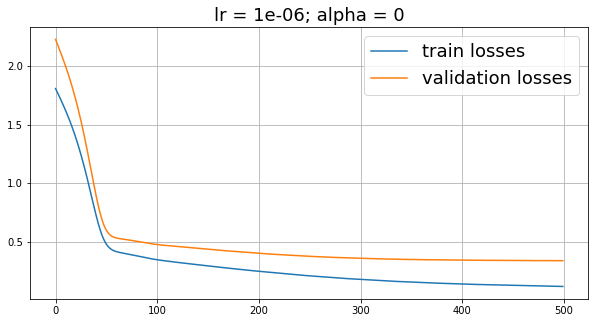

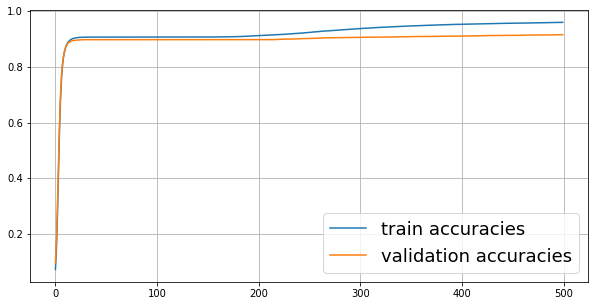

In [19]:
plot_train_progress(LEARNING_RATE, ALPHA, train_losses, val_losses, train_accs, val_accs)

CrossEntropyLoss (dropout)

In [18]:
print(f'Precision:', precision_score(test_labels, preds))
print(f'Recall:', recall_score(test_labels, preds))
print(f'Entity-level f1: {str(f1_score(test_labels, preds))}')
print(f'Report:\n {str(classification_report(test_labels, preds))}')

Precision: 0.7486263736263736
Recall: 0.4339171974522293
Entity-level f1: 0.5493951612903225
Report:
            precision    recall  f1-score   support

      OBJ       0.79      0.47      0.59      1092
 PREDFULL       0.39      0.20      0.26       164

micro avg       0.75      0.43      0.55      1256
macro avg       0.74      0.43      0.55      1256



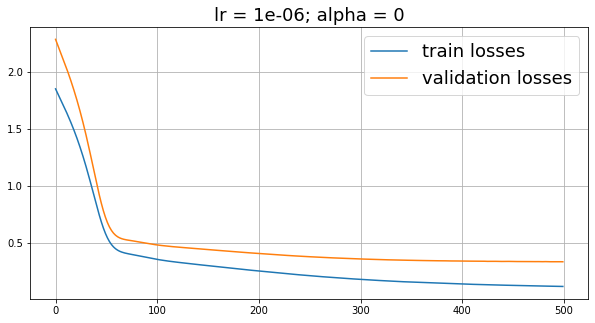

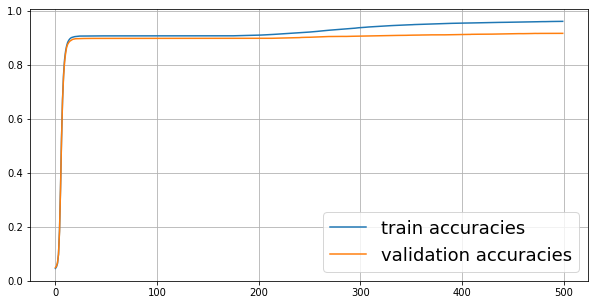

In [19]:
plot_train_progress(LEARNING_RATE, ALPHA, train_losses, val_losses, train_accs, val_accs)